In [2]:
import subprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import scikitplot as skplt
import seaborn as sns
import duckdb
import os
import phik
from sklearn import linear_model
import statsmodels.api as sm

# Exploration of the results
This notebook collects the model results from the CSV files, contains the analysis of the results and generates the figures and tables for the report.

In [3]:
# Connect to Duck DB database file
con = duckdb.connect('data/db/collection.duckdb')

## Create a result table and load in the data
The first part was used for the setup where the results only had one classification per segment. The second part is used for loading in the results with up to 5 classifications per timeframe.

In [32]:
con.sql('''
    DROP TABLE model_results;
''')

con.sql('''
    CREATE TABLE model_results (
        sensor VARCHAR,
        start_observation_dt DATETIME,
        class VARCHAR,
        probability DECIMAL
    );
''')

In [42]:
# sensor = '1_041_209'
sensor = '9_035_217'
dir_path = f'data/results/{sensor}/'

# list file and directories
filenames = os.listdir(dir_path)
filenames.sort()

for filename in filenames:
    if filename.endswith('.csv'):
        print('Loading filename:', filename)

        arguments = filename.split('_')
        date = arguments[0]
        time = arguments[1]
        add_hour = arguments[2].split('.')[0]
        results = pd.read_csv(dir_path + filename)

        con.sql(f'''
            INSERT INTO model_results
            SELECT
                '{sensor}' AS sensor,
                strptime('{date} {time}', '%Y%m%d %H%M%S') +
                INTERVAL (frame * 5) SECOND +
                INTERVAL {add_hour} HOUR AS start_observation_dt,
                class,
                probability
            FROM
                results
            LIMIT
                720;
        ''')


Loading filename: 20221230_143000_0.csv
Loading filename: 20221230_143000_1.csv
Loading filename: 20221230_143000_2.csv
Loading filename: 20221230_213000_0.csv
Loading filename: 20221230_213000_1.csv
Loading filename: 20221230_213000_2.csv
Loading filename: 20221231_000000_0.csv
Loading filename: 20221231_060000_0.csv
Loading filename: 20221231_060000_1.csv
Loading filename: 20221231_060000_2.csv
Loading filename: 20221231_143000_0.csv
Loading filename: 20221231_143000_1.csv
Loading filename: 20221231_143000_2.csv
Loading filename: 20221231_213000_0.csv
Loading filename: 20221231_213000_1.csv
Loading filename: 20221231_213000_2.csv
Loading filename: 20230101_000000_0.csv
Loading filename: 20230101_060000_0.csv
Loading filename: 20230101_060000_1.csv
Loading filename: 20230101_060000_2.csv
Loading filename: 20230101_143000_0.csv
Loading filename: 20230101_143000_1.csv
Loading filename: 20230101_143000_2.csv
Loading filename: 20230101_213000_0.csv
Loading filename: 20230101_213000_1.csv


In [3]:
con.sql('''
    CREATE TABLE model_multi_results (
        sensor VARCHAR,
        start_observation_dt DATETIME,
        class VARCHAR,
        probability DECIMAL,
        probability_rank INTEGER
    );
''')

In [307]:
# sensor = '1_041_209'
sensor = '9_035_217'
dir_path = f'data/multi_results/{sensor}/'

# list file and directories
filenames = os.listdir(dir_path)
filenames.sort()

for filename in filenames:
    if filename.endswith('.csv'):
        print('Loading filename:', filename)

        arguments = filename.split('_')
        date = arguments[0]
        time = arguments[1].split('.')[0]
        results = pd.read_csv(dir_path + filename)

        con.sql(f'''
            INSERT INTO model_multi_results
            SELECT
                '{sensor}' AS sensor,
                strptime('{date} {time}', '%Y%m%d %H%M%S') +
                INTERVAL 1 HOUR +
                INTERVAL (frame * 5) SECOND AS start_observation_dt,
                class,
                probability,
                probability_rank
            FROM
                results;
        ''')


Loading filename: 20221230_143000.csv
Loading filename: 20221230_213000.csv
Loading filename: 20221231_000001.csv
Loading filename: 20221231_060000.csv
Loading filename: 20221231_143000.csv
Loading filename: 20221231_213000.csv
Loading filename: 20230101_000001.csv
Loading filename: 20230101_060000.csv
Loading filename: 20230101_143000.csv
Loading filename: 20230101_213000.csv
Loading filename: 20230102_000001.csv
Loading filename: 20230102_060000.csv
Loading filename: 20230102_143000.csv
Loading filename: 20230102_213000.csv
Loading filename: 20230103_000001.csv
Loading filename: 20230103_060000.csv
Loading filename: 20230103_143000.csv
Loading filename: 20230103_213000.csv
Loading filename: 20230104_000001.csv
Loading filename: 20230104_060000.csv
Loading filename: 20230104_143000.csv
Loading filename: 20230104_213000.csv
Loading filename: 20230105_000001.csv
Loading filename: 20230105_060000.csv
Loading filename: 20230105_143000.csv
Loading filename: 20230105_213000.csv
Loading file

## Explorative queries
This section contains exploratory queries on the model results.

In [6]:
df = con.sql('''
    SELECT
        sensor,
        class,
        CAST(start_observation_dt AS DATE) AS obs_date,
        COUNT(*) AS obs_cnt
    FROM
        model_results
    WHERE
        probability > 0.7
    GROUP BY
        sensor,
        class,
        obs_date
    ORDER BY
        sensor,
        obs_date,
        obs_cnt DESC
''').to_df()

In [7]:
# pd.set_option('display.max_rows', 10)
df

,sensor,class,obs_date,obs_cnt
0,1_041_209,blawoo1,2022-12-30,96
1,1_041_209,gretit1,2022-12-30,16
2,1_041_209,lottit1,2022-12-30,8
3,1_041_209,shttre1,2022-12-30,3
4,1_041_209,eurbla,2022-12-30,3
...,...,...,...,...
547,9_035_217,whoswa,2023-01-08,1
548,9_035_217,wiltit1,2023-01-08,1
549,9_035_217,comkin1,2023-01-08,1
550,9_035_217,eurjac,2023-01-08,1


In [80]:
con.sql('''
    SELECT DISTINCT
        class
    FROM
        model_multi_results
    WHERE
        probability > 0.8
''').to_df()

,class
0,sonthr1
1,slcant2
2,eurcur
3,loeowl
4,brnowl
...,...
79,barswa
80,eurnig1
81,fiediu1
82,zitcis1


In [8]:
df = con.sql('''
    SELECT
        mr.sensor,
        CAST(start_observation_dt AS DATE) AS obs_date,
        HOUR(mr.start_observation_dt) AS obs_hour,
        mr.class,
        COUNT(*) AS obs_cnt
    FROM
        model_results AS mr
    WHERE
        mr.probability > 0.7
    GROUP BY
        mr.sensor,
        obs_date,
        obs_hour,
        mr.class
    ORDER BY
        mr.sensor,
        obs_date,
        obs_hour,
        mr.class
''').to_df()

In [9]:
df

,sensor,obs_date,obs_hour,class,obs_cnt
0,1_041_209,2022-12-30,14,blawoo1,7
1,1_041_209,2022-12-30,14,comrav,1
2,1_041_209,2022-12-30,14,eurcoo,1
3,1_041_209,2022-12-30,14,eurnut2,1
4,1_041_209,2022-12-30,14,gretit1,9
...,...,...,...,...,...
1121,9_035_217,2023-01-08,8,grswoo,26
1122,9_035_217,2023-01-08,8,gwfgoo,2
1123,9_035_217,2023-01-08,8,lottit1,5
1124,9_035_217,2023-01-08,8,martit2,1


In [1]:
# df.to_excel('data/output/results.xlsx')

In [316]:
# SUM(CASE WHEN sensor = '1_041_209' THEN probability ELSE 0 END) AS city_prob,
# SUM(CASE WHEN sensor = '9_035_217' THEN probability ELSE 0 END) AS forest_prob
con.sql('''
    SELECT
        mr.*,
        CAST(mr.start_observation_dt AS DATE) AS obs_date,
        HOUR(mr.start_observation_dt) AS obs_hour,
        rn.rain
    FROM
        model_multi_results as mr
    LEFT JOIN
        rain_per_hour AS rn
    ON
        CAST(mr.start_observation_dt AS DATE) = rn.date AND
        HOUR(mr.start_observation_dt) = rn.hour
    WHERE
        obs_date < '2023-01-08' AND
        mr.class IN (
            SELECT eBirdCode
            FROM ebird_in_netherlands
        )
    USING
        SAMPLE 20
''').to_df()

,sensor,start_observation_dt,class,probability,probability_rank,obs_date,obs_hour,rain
0,9_035_217,2022-12-31 08:24:30,comchi1,0.010,5,2022-12-31,8,3.44
1,9_035_217,2023-01-07 17:11:25,commoo3,0.018,4,2023-01-07,17,0.70
2,1_041_209,2023-01-05 00:24:00,eueowl1,0.064,2,2023-01-05,0,0.00
3,1_041_209,2023-01-06 23:43:25,eurcoo,0.071,3,2023-01-06,23,0.27
4,9_035_217,2023-01-02 17:36:50,tawowl1,0.065,2,2023-01-02,17,0.10
5,9_035_217,2023-01-03 22:51:05,eueowl1,0.024,5,2023-01-03,22,0.00
6,1_041_209,2023-01-03 18:29:05,watrai1,0.040,4,2023-01-03,18,0.00
7,9_035_217,2022-12-31 22:55:50,eurcoo,0.029,3,2022-12-31,22,0.00
8,1_041_209,2023-01-02 00:10:15,eurnig1,0.020,4,2023-01-02,0,0.00
9,1_041_209,2023-01-01 01:23:01,ortbun1,0.026,4,2023-01-01,1,0.00


## Poisson Regressions
This section contains the code for performing the Poisson Regressions.

In [4]:
# SUM(CASE WHEN sensor = '1_041_209' THEN probability ELSE 0 END) AS city_prob,
# SUM(CASE WHEN sensor = '9_035_217' THEN probability ELSE 0 END) AS forest_prob
df = con.sql('''
    SELECT
        CAST(mr.start_observation_dt AS DATE) AS obs_date,
        HOUR(mr.start_observation_dt) AS obs_hour,
        CASE WHEN MINUTE(mr.start_observation_dt) < 30 THEN 1 ELSE 2 END AS obs_half_hour,
        CASE WHEN sensor = '1_041_209' THEN 1 ELSE 0 END AS city_ind,
        MAX(rn.rain) / 2 AS total_rain,
        COUNT(*) AS total_cnt,
        COUNT(DISTINCT class) AS distinct_cnt,
        CASE
            WHEN obs_date = '2022-12-31' AND obs_hour IN (15, 16, 17, 18) THEN 1
            ELSE 0
        END AS firework_evening_ind,
        CASE
            WHEN obs_date = '2022-12-31' AND obs_hour IN (22, 23) THEN 1
            WHEN obs_date = '2023-01-01' AND obs_hour IN (0, 1) THEN 1
            ELSE 0
        END AS firework_night_ind,
        CASE
            WHEN obs_date = '2023-01-01' AND obs_hour IN (7, 8, 9) THEN 1
            ELSE 0
        END AS firework_morning_ind,
        CASE
            WHEN obs_date = '2023-01-01' AND obs_hour IN (15, 16, 17, 18) THEN 1
            ELSE 0
        END AS firework_afternoon_ind,
        GREATEST(firework_evening_ind, firework_night_ind, firework_morning_ind, firework_afternoon_ind) AS firework_ind,
        CASE WHEN obs_hour IN (7, 8, 9) THEN 1 ELSE 0 END AS morning_ind,
        CASE WHEN obs_hour IN (15, 16, 17, 18) THEN 1 ELSE 0 END AS afternoon_ind,
        CASE WHEN obs_hour IN (22, 23, 0, 1) THEN 1 ELSE 0 END AS night_ind
    FROM
        model_multi_results as mr
    LEFT JOIN
        rain_per_hour AS rn
    ON
        CAST(mr.start_observation_dt AS DATE) = rn.date AND
        HOUR(mr.start_observation_dt) = rn.hour
    WHERE
        obs_date < '2023-01-08' AND
        mr.probability >= 0.39 AND
        mr.class IN (
            SELECT eBirdCode
            FROM ebird_in_netherlands
        )
    GROUP BY
        obs_date,
        obs_hour,
        obs_half_hour,
        city_ind
    ORDER BY
        obs_date,
        obs_hour,
        obs_half_hour,
        city_ind
''').to_df()

The following code generates the sample data for the appendix.

In [61]:
print(con.sql('''
    SELECT
        obs_date AS "Date",
        obs_hour AS "Hour",
        obs_half_hour AS "Half hour",
        city_ind AS "City ind.",
        total_rain AS "Rain (in mm)",
        morning_ind AS "Morning ind.",
        afternoon_ind AS "P.M. ind.",
        night_ind AS "Night ind.",
        firework_ind AS "Fw. ind.",
        firework_evening_ind AS "Fw. NYE P.M. ind.",
        firework_night_ind AS "Fw. NYE night ind.",
        firework_morning_ind AS "Fw. NYD A.M. ind.",
        firework_afternoon_ind AS "Fw. NYD P.M. ind.",
        total_cnt AS "Total count",
        distinct_cnt AS "Distinct count"
    FROM
        df
    USING
        SAMPLE 10
    ORDER BY
        obs_date,
        obs_hour,
        obs_half_hour,
        city_ind
''').to_df().transpose().to_latex(index=False))

\begin{tabular}{llllllllll}
\toprule
                  0 &                   1 &                   2 &                   3 &                   4 &                   5 &                   6 &                   7 &                   8 &                   9 \\
\midrule
2022-12-31 00:00:00 & 2022-12-31 00:00:00 & 2022-12-31 00:00:00 & 2022-12-31 00:00:00 & 2023-01-01 00:00:00 & 2023-01-01 00:00:00 & 2023-01-02 00:00:00 & 2023-01-04 00:00:00 & 2023-01-06 00:00:00 & 2023-01-06 00:00:00 \\
                  1 &                  15 &                  16 &                  18 &                   1 &                  23 &                  18 &                   8 &                   0 &                  16 \\
                  1 &                   2 &                   2 &                   1 &                   1 &                   2 &                   1 &                   1 &                   2 &                   1 \\
                  0 &                   0 &                   0 &     

/var/folders/s_/42fztgr17fz_p63wzy307yvh0000gn/T/ipykernel_6070/479722852.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(con.sql('''


In [5]:
# Determine the independent variables
x_data = df[['city_ind', 'total_rain', 'morning_ind', 'afternoon_ind', 'firework_ind', 'firework_evening_ind', 'firework_morning_ind', 'firework_afternoon_ind']]

### Setup using scikit-learn
The initial version used scikit-learn, in the end, statsmodels was used because it offers better summaries.

In [418]:
clf = linear_model.PoissonRegressor(fit_intercept=True, max_iter=1000, tol=1e-8)

In [420]:
clf.fit(x_data, df[['total_cnt']].values.ravel())

PoissonRegressor(max_iter=1000, tol=1e-08)

In [421]:
clf.coef_

array([ 0.47488064, -0.23806506, -0.40994713, -0.40964011, -0.27230314,
        0.39831201,  1.34084738,  0.78850881])

In [422]:
clf.intercept_

3.148803175608731

In [423]:
clf.n_iter_

24

### Setup using statsmodels

In [6]:
X_with_intercept = sm.add_constant(x_data)

In [7]:
model_sm = sm.GLM(df[['total_cnt']], X_with_intercept, family=sm.families.Poisson()).fit()

In [8]:
model_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              total_cnt   No. Observations:                  303
Model:                            GLM   Df Residuals:                      294
Model Family:                 Poisson   Df Model:                            8
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -7891.3
Date:                Thu, 29 Jun 2023   Deviance:                       14208.
Time:                        19:18:39   Pearson chi2:                 1.39e+04
No. Iterations:                     6   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      2.9114      0.024    122.060      0.000       2.865       2.958
city_ind                   0.5063      0.015     34.669      0.000       0.478       0.535
total_rain                -0.2859      0.017    -17.287      0.000      -0.318      -0.253
morning_ind                1.6274      0.024     66.629      0.000       1.579       1.675
afternoon_ind              1.0516      0.026     41.092      0.000       1.001       1.102
firework_ind              -0.9105      0.095     -9.620      0.000      -1.096      -0.725
firework_evening_ind       0.1897      0.108      1.763      0.078      -0.021       0.401
firework_morning_ind       0.4891      0.100      4.868      0.000       0.292       0.686
firework_afternoon_ind     1.3610      0.099     13.683      0.000       1.166       1.556
==========================================================================================
"""

In [9]:
# Code used to make example predictions
print(model_sm.predict([1, 0, 0, 0, 1, 0, 0, 0, 0])[0])

52.61401655009276


In [10]:
# Look at the residuals
residuals = model_sm.resid_response
residuals

0     -39.635794
1     -18.695382
2     -27.117957
3       4.845447
4     -37.117957
         ...    
298    16.499948
299    -3.382641
300    28.499948
301     1.617359
302   -28.500052
Length: 303, dtype: float64

<Axes: >

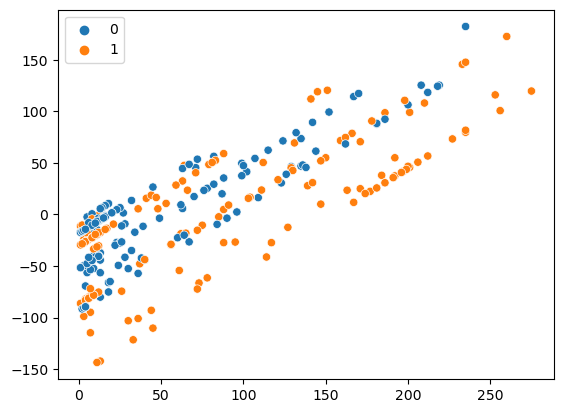

In [11]:
sns.scatterplot(x=df[['total_cnt']].values.ravel(), y=residuals, hue=df[['city_ind']].values.ravel())

<Axes: xlabel='total_cnt', ylabel='total_rain'>

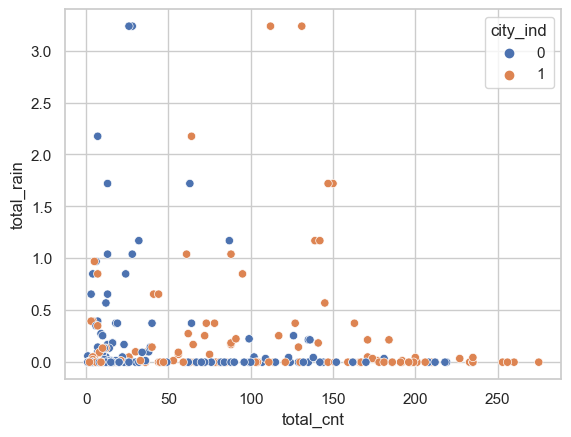

In [63]:
sns.scatterplot(data=df, x='total_cnt', y='total_rain', hue='city_ind')

In [12]:
model_sm = sm.GLM(df[['distinct_cnt']], X_with_intercept, family=sm.families.Poisson()).fit()

In [13]:
model_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           distinct_cnt   No. Observations:                  303
Model:                            GLM   Df Residuals:                      294
Model Family:                 Poisson   Df Model:                            8
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -965.06
Date:                Thu, 29 Jun 2023   Deviance:                       841.24
Time:                        19:19:45   Pearson chi2:                     794.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.7983
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      1.3095      0.061     21.587      0.000       1.191       1.428
city_ind                   0.0256      0.041      0.619      0.536      -0.055       0.107
total_rain                -0.4171      0.060     -6.995      0.000      -0.534      -0.300
morning_ind                1.1567      0.067     17.371      0.000       1.026       1.287
afternoon_ind              0.8890      0.067     13.192      0.000       0.757       1.021
firework_ind              -0.1964      0.174     -1.129      0.259      -0.537       0.145
firework_evening_ind      -0.0446      0.208     -0.214      0.830      -0.452       0.363
firework_morning_ind       0.1593      0.197      0.809      0.418      -0.227       0.545
firework_afternoon_ind     0.5242      0.195      2.682      0.007       0.141       0.907
==========================================================================================
"""

In [14]:
residuals = model_sm.resid_response
residuals

0     -2.034914
1      3.756451
2      3.605381
3      2.387406
4     -0.394619
         ...   
298    5.199622
299    2.295805
300    1.199622
301    2.295805
302   -1.800378
Length: 303, dtype: float64

<Axes: >

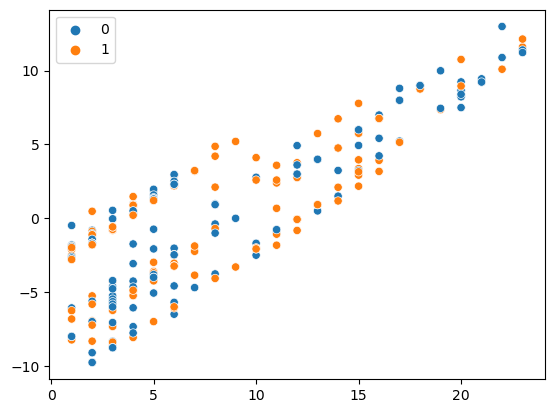

In [15]:
sns.scatterplot(x=df[['distinct_cnt']].values.ravel(), y=residuals, hue=df[['city_ind']].values.ravel())

## Further data explorations and visualizations

In [48]:
# SUM(CASE WHEN sensor = '1_041_209' THEN probability ELSE 0 END) AS city_prob,
# SUM(CASE WHEN sensor = '9_035_217' THEN probability ELSE 0 END) AS forest_prob
df = con.sql('''
    SELECT
        CAST(mr.start_observation_dt AS DATE) AS obs_date,
        LPAD(HOUR(mr.start_observation_dt), 2, '0') AS obs_hour,
        CASE WHEN MINUTE(mr.start_observation_dt) < 30 THEN 1 ELSE 2 END AS obs_half_hour,
        MAX(rn.rain) / 2 AS total_rain,
        MAX(CASE WHEN rn.rain > 0 THEN 1 ELSE 0 END) AS rain_ind,
        SUM(CASE WHEN mr.sensor = '1_041_209' THEN 1 ELSE 0 END) AS city_cnt,
        SUM(CASE WHEN mr.sensor = '9_035_217' THEN 1 ELSE 0 END) AS forest_cnt,
        COUNT(*) AS total_cnt,
        COUNT(DISTINCT class) AS distinct_cnt
    FROM
        model_multi_results as mr
    LEFT JOIN
        rain_per_hour AS rn
    ON
        CAST(mr.start_observation_dt AS DATE) = rn.date AND
        HOUR(mr.start_observation_dt) = rn.hour
    WHERE
        obs_date < '2023-01-08' AND
        mr.probability >= 0.39 AND
        mr.class IN (
            SELECT eBirdCode
            FROM ebird_in_netherlands
        )
    GROUP BY
        obs_date,
        obs_hour,
        obs_half_hour
    ORDER BY
        obs_date,
        obs_hour,
        obs_half_hour
''').to_df()

In [49]:
pd.set_option('display.max_rows', 30)
df['obs_time'] = df['obs_hour'].astype(str) + '.' + df['obs_half_hour'].astype(str)
df

,obs_date,obs_hour,obs_half_hour,total_rain,rain_ind,city_cnt,forest_cnt,total_cnt,distinct_cnt,obs_time
0,2022-12-30,15,2,0.275,1,62.0,9.0,71,16,15.2
1,2022-12-30,16,1,0.170,1,88.0,23.0,111,20,16.1
2,2022-12-30,16,2,0.170,1,65.0,13.0,78,11,16.2
3,2022-12-30,17,1,0.075,1,56.0,9.0,65,5,17.1
4,2022-12-30,17,2,0.075,1,75.0,7.0,82,8,17.2
...,...,...,...,...,...,...,...,...,...,...
148,2023-01-07,17,2,0.000,0,9.0,8.0,17,7,17.2
149,2023-01-07,18,1,0.350,1,7.0,6.0,13,7,18.1
150,2023-01-07,22,2,0.000,0,47.0,16.0,63,13,22.2
151,2023-01-07,23,1,0.000,0,59.0,15.0,74,8,23.1


<Axes: >

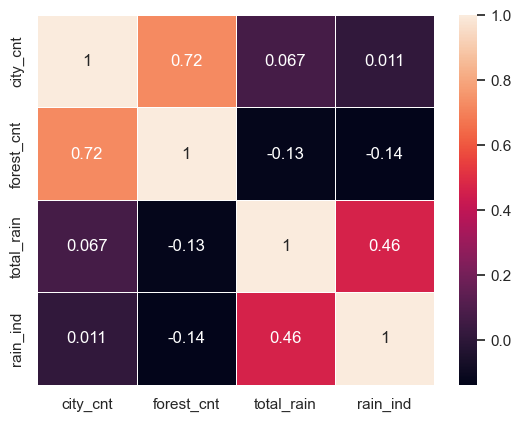

In [50]:
sns.heatmap(df[['city_cnt', 'forest_cnt', 'total_rain', 'rain_ind']].corr(), annot=True, linewidth=.5)

In [385]:
print(df['forest_cnt'].corr(df['total_rain']))
print(df['forest_cnt'].corr(df['rain_ind']))

-0.15947852566694767Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.

-0.18108746782082172
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [386]:
print(df['city_cnt'].corr(df['total_rain']))
print(df['city_cnt'].corr(df['rain_ind']))

-0.03174318990725444Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.

-0.07461313090546524
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


<Axes: xlabel='obs_time', ylabel='total_cnt'>

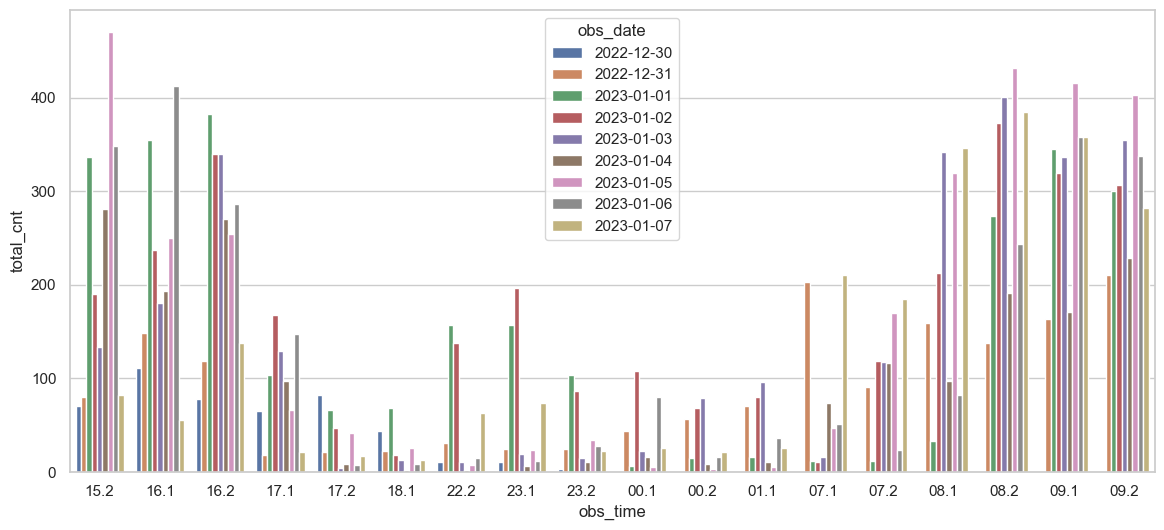

In [587]:
plt.figure(figsize=(14, 6))

hue_dates = df['obs_date'].dt.strftime('%Y-%m-%d')

sns.barplot(data=df, x="obs_time", y="total_cnt", hue=hue_dates)

<Axes: xlabel='obs_time', ylabel='distinct_cnt'>

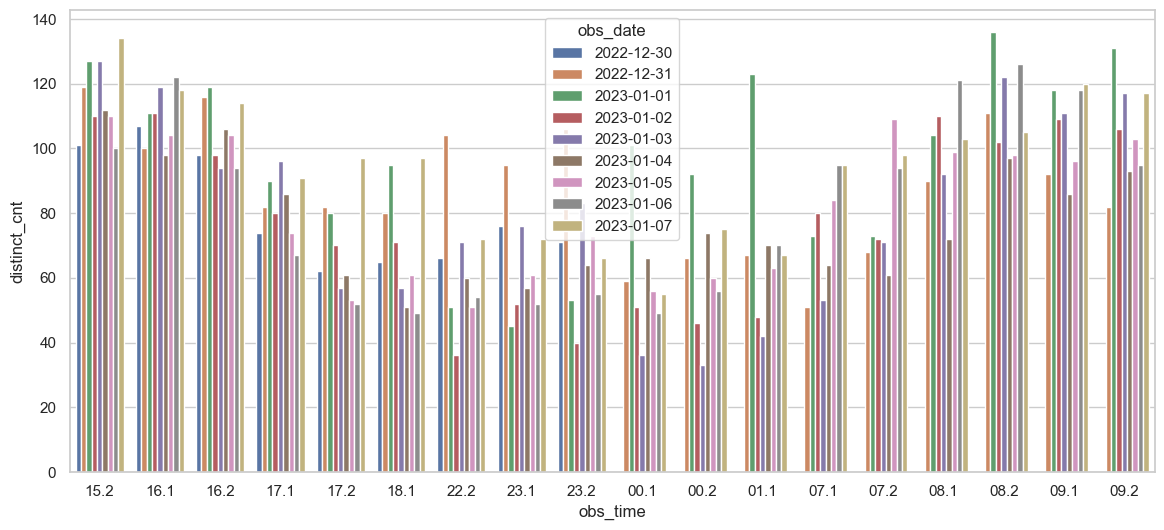

In [531]:
plt.figure(figsize=(14, 6))
sns.barplot(data=df, x="obs_time", y="distinct_cnt", hue=hue_dates)

<Axes: xlabel='obs_hour', ylabel='total_rain'>

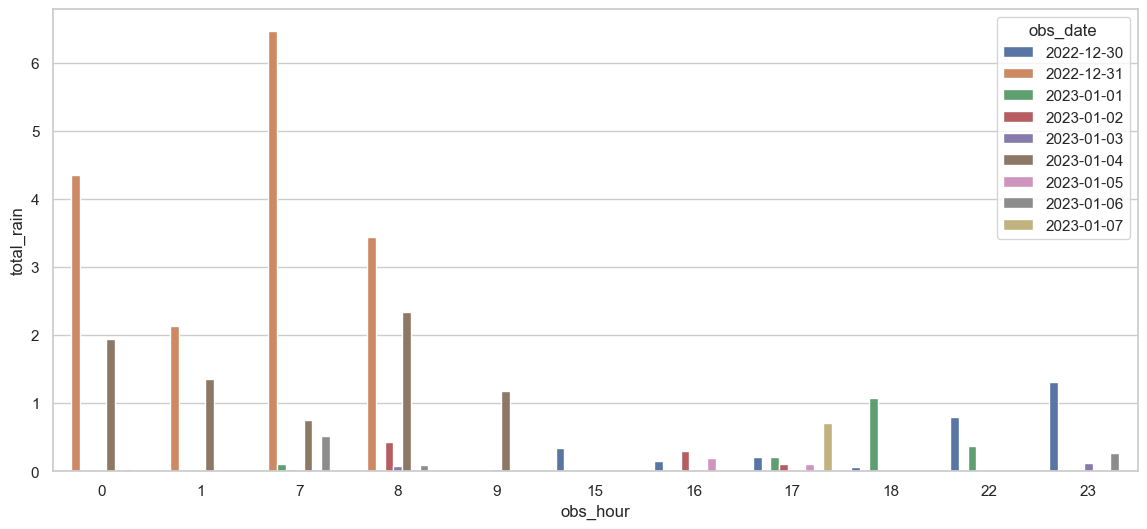

In [311]:
plt.figure(figsize=(14, 6))

hue_dates = df['obs_date'].dt.strftime('%Y-%m-%d')

sns.barplot(data=df, x="obs_hour", y="total_rain", hue=hue_dates)

In [656]:
def plot_rain_obs_graph(df, obs_var_name, save_name = 'data/images/plot.png'):
    hue_dates = df['obs_date'].dt.strftime('%Y-%m-%d')
    
    plot_order = df['obs_time'].unique()
    plot_order.sort()
    
    sns.set_theme(style='whitegrid')
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 14), sharey=True, width_ratios=[2,3], gridspec_kw={'wspace': 0})

    # draw observations subplot at the right
    sns.barplot(data=df, x=obs_var_name, y="obs_time", hue=hue_dates, order=plot_order,
                errorbar=('ci', False), orient='horizontal', dodge=True, ax=ax2)
    ax2.yaxis.set_label_position('right')
    ax2.tick_params(axis='y', labelright=True, right=True)
    ax2.set_xlabel('amount of observations')
    ax2.set_ylabel('time in hours with indication of first or second half hour')
    # ax2.set_title('  '+'observations', loc='left')
    ax2.legend_.remove()  # remove the legend; the legend will be in ax1

    # draw rain subplot at the left
    sns.barplot(data=df, x="total_rain", y="obs_time", hue=hue_dates, order=plot_order,
                errorbar=('ci', False), orient='horizontal', dodge=True, ax=ax1)

    ax1.invert_xaxis()  # reverse the direction
    ax1.tick_params(labelleft=False, left=False)
    ax1.set_xlabel('amount of rain in mm')
    ax1.set_ylabel('')
    ax1.legend_.set_title('Date')
    # ax1.set_title('rain'+'  ', loc='right')
    
    location = 'city' if obs_var_name == 'city_cnt' else 'forest'
    
    fig.suptitle(f'Amount of rain and observations for {location} sensor', fontdict={'size': 14})

    plt.tight_layout()
    plt.subplots_adjust(top=0.965)
    plt.savefig(save_name, bbox_inches="tight")
    plt.show()

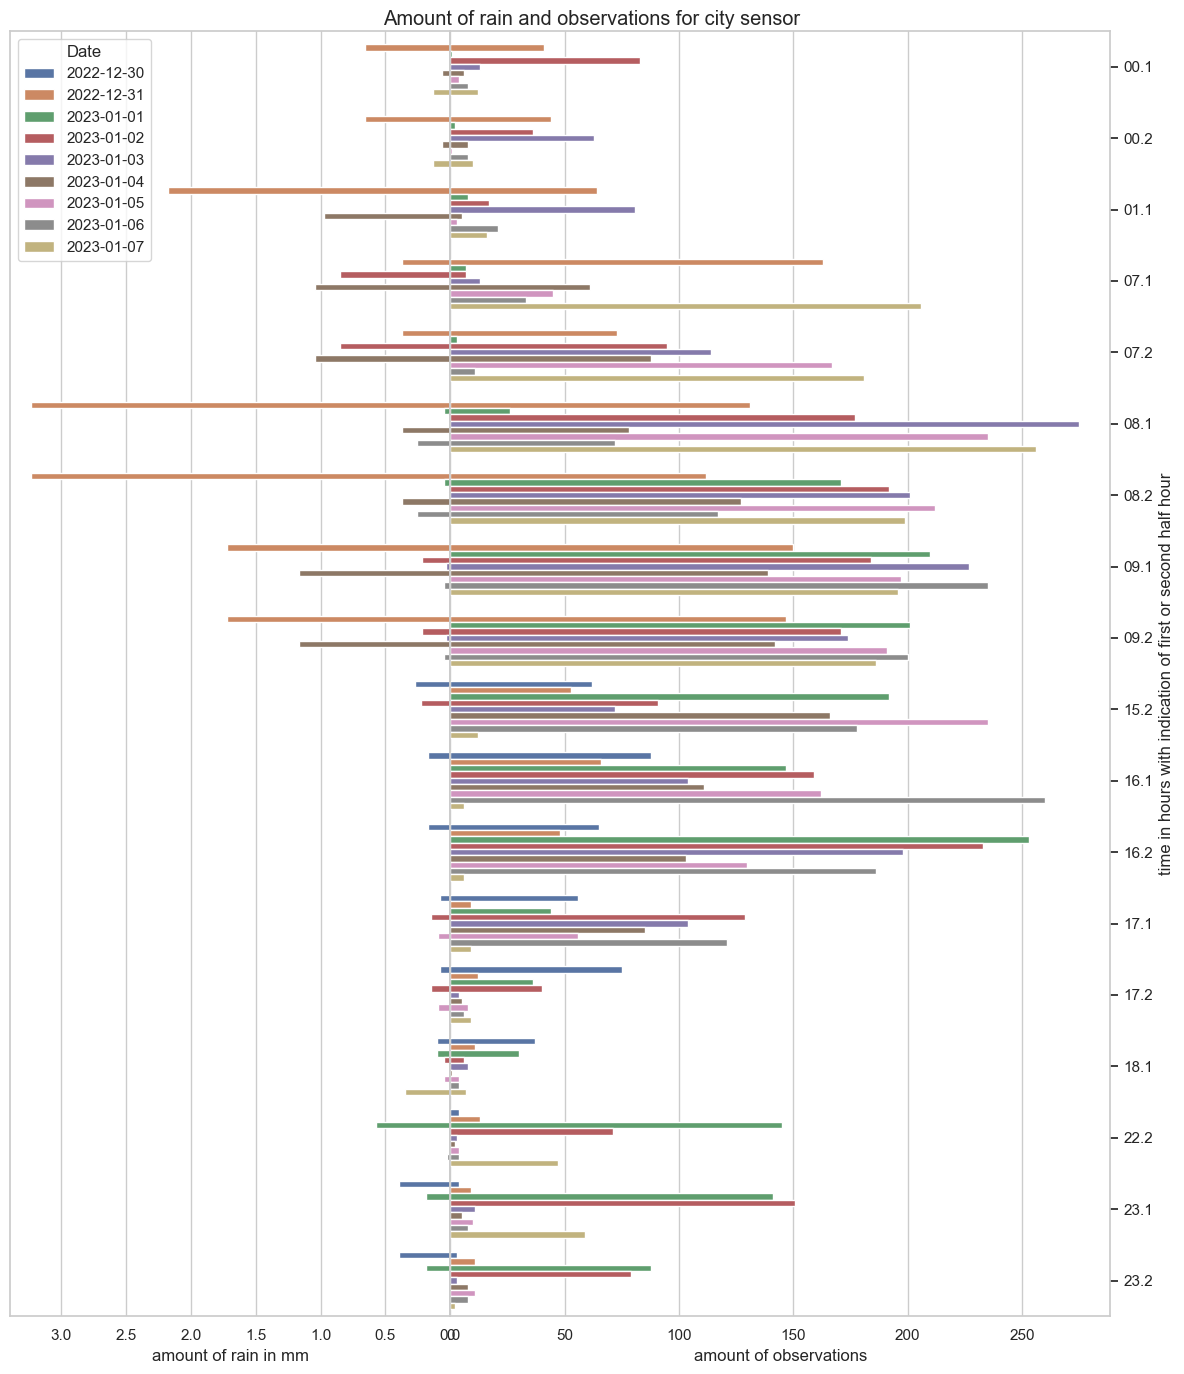

In [657]:
plot_rain_obs_graph(df, "city_cnt", save_name="data/images/number_of_obs_and_rain_s1.png")

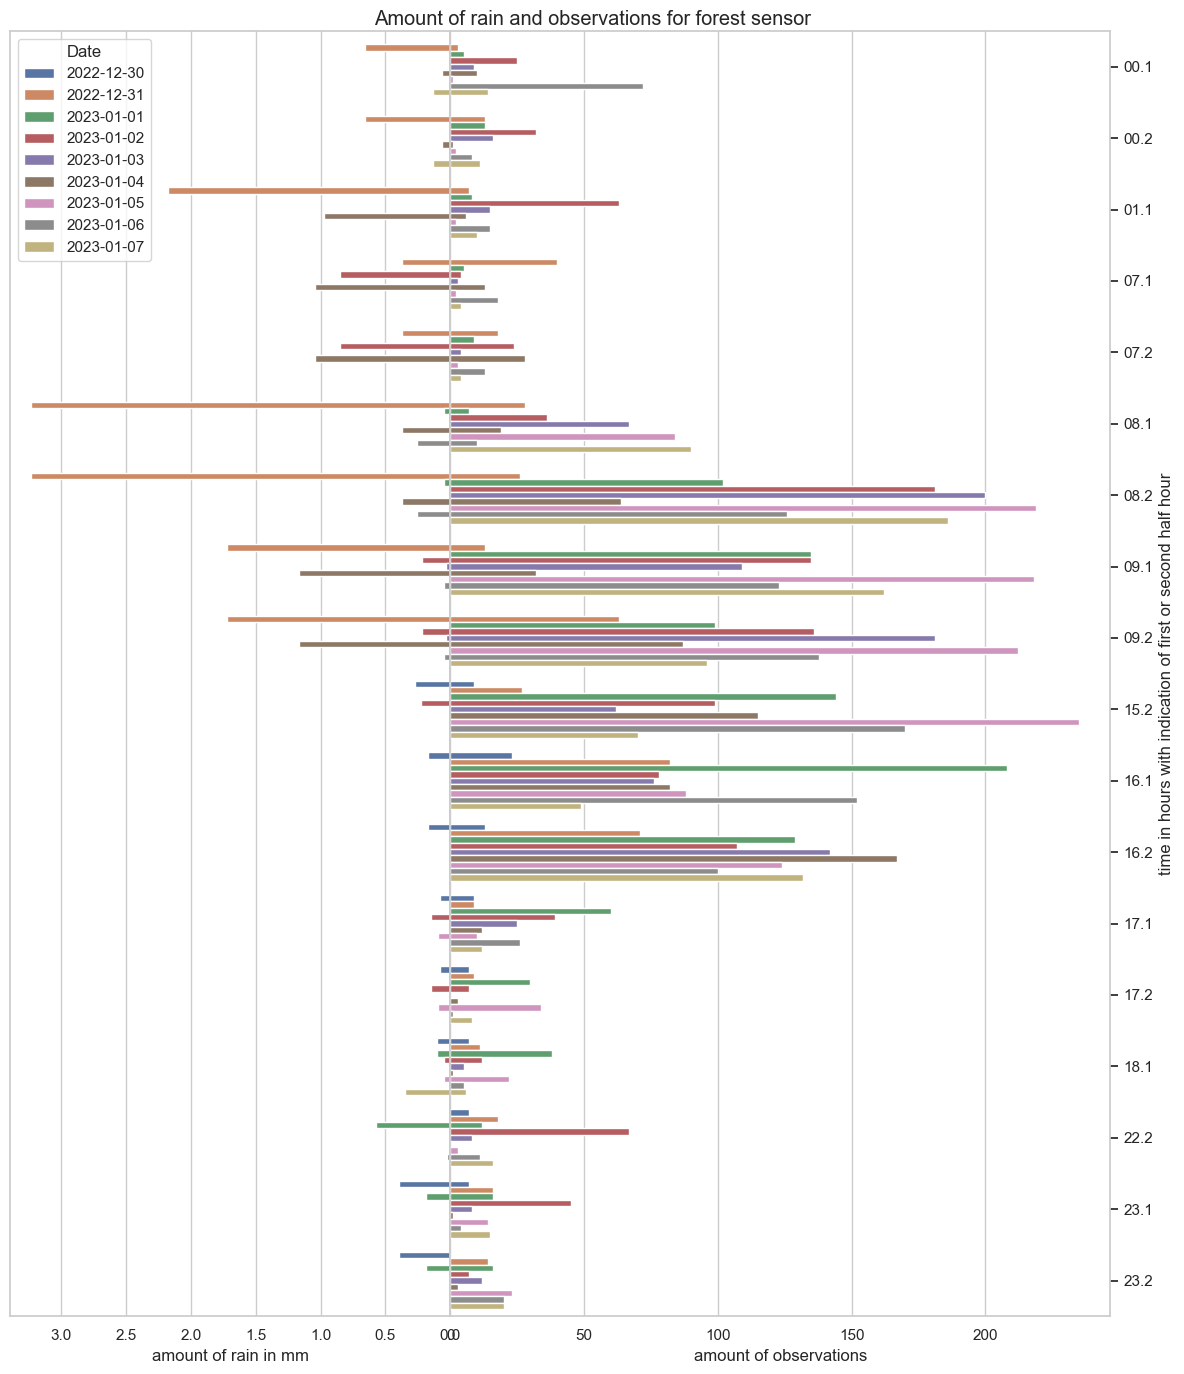

In [658]:
plot_rain_obs_graph(df, "forest_cnt", save_name="data/images/number_of_obs_and_rain_s9.png")

In [582]:
# mr.sensor = '9_035_217' AND
df = con.sql('''
    SELECT
        CAST(mr.start_observation_dt AS DATE) AS obs_date,
        HOUR(mr.start_observation_dt) AS obs_hour,
        CASE WHEN MINUTE(mr.start_observation_dt) < 30 THEN 1 ELSE 2 END AS obs_half_hour,
        MAX(rn.rain) / 2 AS total_rain,
        COUNT(DISTINCT mr.class) AS total_classes
    FROM
        model_multi_results as mr
    LEFT JOIN
        rain_per_hour AS rn
    ON
        CAST(mr.start_observation_dt AS DATE) = rn.date AND
        HOUR(mr.start_observation_dt) = rn.hour
    WHERE
        mr.sensor = '1_041_209' AND
        mr.probability >= 0.39 AND
        obs_date < '2023-01-08' AND
        mr.class IN (
            SELECT eBirdCode
            FROM ebird_in_netherlands
        )
    GROUP BY
        obs_date,
        obs_hour,
        obs_half_hour
    ORDER BY
        obs_date,
        obs_hour,
        obs_half_hour
''').to_df()

In [583]:
df['obs_time'] = df['obs_hour'].astype(str) + '.' + df['obs_half_hour'].astype(str)

In [584]:
df

,obs_date,obs_hour,obs_half_hour,total_rain,total_classes,obs_time
0,2022-12-30,15,2,0.275,12,15.2
1,2022-12-30,16,1,0.170,11,16.1
2,2022-12-30,16,2,0.170,5,16.2
3,2022-12-30,17,1,0.075,2,17.1
4,2022-12-30,17,2,0.075,4,17.2
...,...,...,...,...,...,...
148,2023-01-07,17,2,0.000,6,17.2
149,2023-01-07,18,1,0.350,5,18.1
150,2023-01-07,22,2,0.000,9,22.2
151,2023-01-07,23,1,0.000,5,23.1


<Axes: >

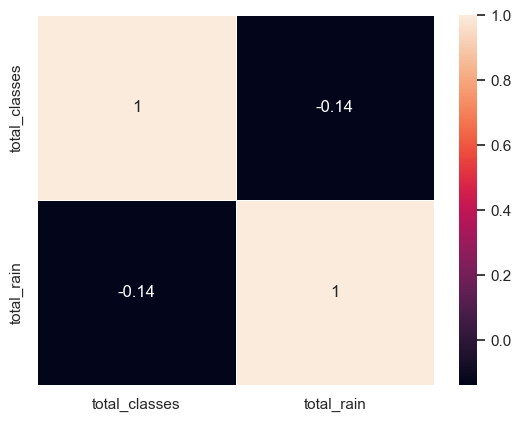

In [371]:
sns.heatmap(df[['total_classes', 'total_rain']].corr(), annot=True, linewidth=.5)

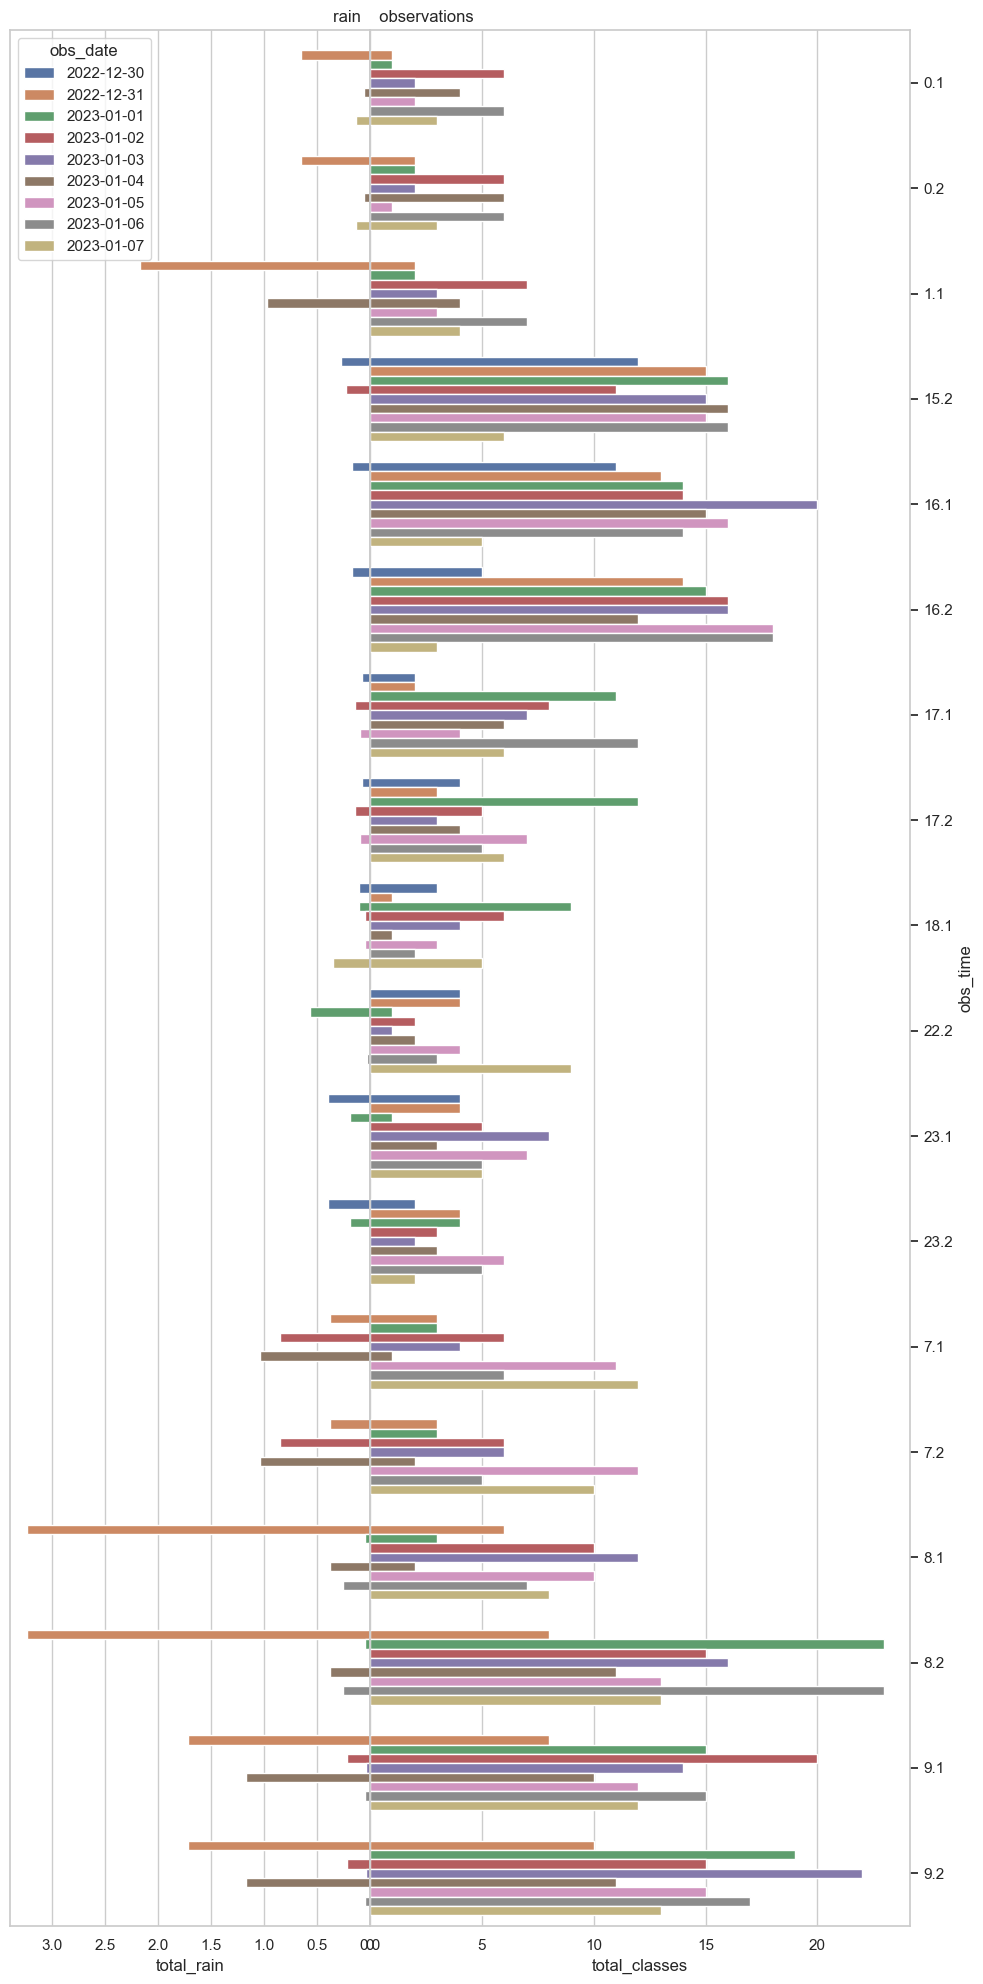

In [367]:
plot_rain_obs_graph(df, "total_classes")

In [347]:
df = con.sql('''
    SELECT
        CAST(mr.start_observation_dt AS DATE) AS obs_date,
        HOUR(mr.start_observation_dt) AS obs_hour,
        CASE WHEN MINUTE(mr.start_observation_dt) < 30 THEN 1 ELSE 2 END AS obs_half_hour,
        MAX(rn.rain) / 2 AS total_rain,
        SUM(CASE WHEN mr.sensor = '1_041_209' THEN mr.probability ELSE 0 END) AS city_cnt,
        SUM(CASE WHEN mr.sensor = '9_035_217' THEN mr.probability ELSE 0 END) AS forest_cnt,
        SUM(mr.probability) AS total_cnt
    FROM
        model_multi_results as mr
    LEFT JOIN
        rain_per_hour AS rn
    ON
        CAST(mr.start_observation_dt AS DATE) = rn.date AND
        HOUR(mr.start_observation_dt) = rn.hour
    WHERE
        obs_date < '2023-01-08' AND
        mr.class IN (
            SELECT eBirdCode
            FROM ebird_in_netherlands
        )
    GROUP BY
        obs_date,
        obs_hour,
        obs_half_hour
    ORDER BY
        obs_date,
        obs_hour,
        obs_half_hour
''').to_df()

In [348]:
df

,obs_date,obs_hour,obs_half_hour,total_rain,city_cnt,forest_cnt,total_cnt
0,2022-12-30,15,2,0.275,132.690,72.374,205.064
1,2022-12-30,16,1,0.170,145.068,83.871,228.939
2,2022-12-30,16,2,0.170,120.780,81.440,202.220
3,2022-12-30,17,1,0.075,114.999,90.059,205.058
4,2022-12-30,17,2,0.075,121.800,91.092,212.892
...,...,...,...,...,...,...,...
148,2023-01-07,17,2,0.000,81.200,92.922,174.122
149,2023-01-07,18,1,0.350,72.696,69.274,141.970
150,2023-01-07,22,2,0.000,149.988,95.531,245.519
151,2023-01-07,23,1,0.000,150.456,101.309,251.765


<Axes: >

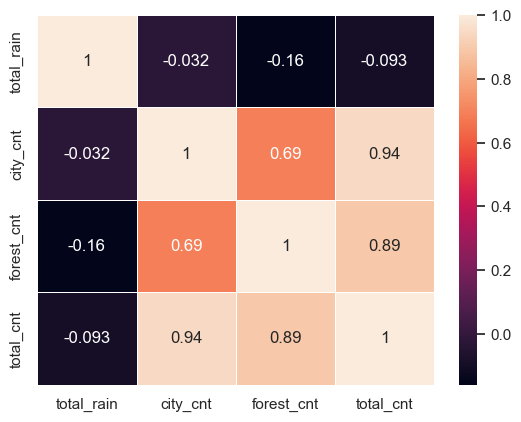

In [368]:
sns.heatmap(df[['total_rain', 'city_cnt', 'forest_cnt', 'total_cnt']].corr(), annot=True, linewidth=.5)

In [28]:
df = con.sql('''
    SELECT
        CAST(mr.start_observation_dt AS DATE) AS obs_date,
        MAX(rn.total_rain) AS rain,
        SUM(CASE WHEN mr.sensor = '1_041_209' AND mr.probability > 0.7 THEN 1 ELSE 0 END) AS city_cnt,
        SUM(CASE WHEN mr.sensor = '9_035_217' AND mr.probability > 0.7 THEN 1 ELSE 0 END) AS forest_cnt
    FROM
        model_results as mr
    LEFT JOIN (
        SELECT date, SUM(rain) AS total_rain
        FROM rain_per_hour
        GROUP BY date
    ) AS rn
    ON
        CAST(mr.start_observation_dt AS DATE) = rn.date
    WHERE
        obs_date < '2023-01-08'
    GROUP BY
        obs_date
    ORDER BY
        obs_date
''').to_df()

In [29]:
df

,obs_date,rain,city_cnt,forest_cnt
0,2022-12-30,4.43,137.0,19.0
1,2022-12-31,26.40,408.0,197.0
2,2023-01-01,5.22,953.0,616.0
3,2023-01-02,4.11,1109.0,602.0
4,2023-01-03,0.28,945.0,538.0
5,2023-01-04,12.25,505.0,315.0
6,2023-01-05,0.31,1004.0,797.0
7,2023-01-06,1.23,882.0,525.0
8,2023-01-07,0.70,805.0,505.0


In [77]:
df = con.sql('''
    SELECT
        class,
        SUM(CASE WHEN sensor = '1_041_209' THEN 1 ELSE 0 END) AS city_cnt,
        SUM(CASE WHEN sensor = '9_035_217' THEN 1 ELSE 0 END) AS forest_cnt
    FROM
        model_results
    WHERE
        CAST(start_observation_dt AS DATE) = '2023-01-01' AND
        HOUR(start_observation_dt) = 15 AND
        probability > 0.7
    GROUP BY
        class
    ORDER BY
        city_cnt DESC
''').to_df()

In [78]:
df

,class,city_cnt,forest_cnt
0,eurbla,127.0,0.0
1,eurnut2,46.0,0.0
2,gretit1,27.0,5.0
3,eurrob1,27.0,2.0
4,shttre1,23.0,60.0
5,martit2,10.0,0.0
6,winwre4,5.0,31.0
7,gwfgoo,2.0,2.0
8,spocra1,2.0,0.0
9,sonthr1,1.0,0.0


In [106]:
# loeowl: Ransuil
# tawowl1: Bosuil
df = con.sql('''
    SELECT
        CAST(start_observation_dt AS DATE) AS obs_date,
        HOUR(start_observation_dt) AS obs_hour,
        SUM(CASE WHEN sensor = '1_041_209' AND class = 'loeowl' AND probability > 0.7 THEN 1 ELSE 0 END) AS city_cnt,
        SUM(CASE WHEN sensor = '9_035_217' AND class = 'loeowl' AND probability > 0.7 THEN 1 ELSE 0 END) AS forest_cnt
    FROM
        model_results
    GROUP BY
        obs_date,
        obs_hour
    ORDER BY
        obs_date,
        obs_hour
''').to_df()

In [107]:
df

,obs_date,obs_hour,city_cnt,forest_cnt
0,2022-12-30,14,0.0,0.0
1,2022-12-30,15,0.0,0.0
2,2022-12-30,16,0.0,0.0
3,2022-12-30,17,0.0,0.0
4,2022-12-30,21,0.0,2.0
5,2022-12-30,22,1.0,0.0
6,2022-12-30,23,0.0,0.0
7,2022-12-31,0,0.0,0.0
8,2022-12-31,6,0.0,0.0
9,2022-12-31,7,0.0,0.0


In [87]:
df = con.sql('''
    SELECT
        class,
        SUM(CASE WHEN sensor = '1_041_209' THEN 1 ELSE 0 END) AS city_cnt,
        SUM(CASE WHEN sensor = '9_035_217' THEN 1 ELSE 0 END) AS forest_cnt
    FROM
        model_results
    WHERE
        probability > 0.7
    GROUP BY
        class
    ORDER BY
        city_cnt DESC
    LIMIT
        20
''').to_df()

In [88]:
df

,class,city_cnt,forest_cnt
0,blawoo1,380.0,39.0
1,gretit1,208.0,22.0
2,eurbla,206.0,29.0
3,eurnut2,157.0,2.0
4,martit2,85.0,8.0
5,eurrob1,83.0,10.0
6,tawowl1,79.0,53.0
7,shttre1,45.0,139.0
8,grswoo,37.0,149.0
9,blutit,34.0,9.0


In [89]:
df = con.sql('''
    SELECT
        class,
        SUM(CASE WHEN sensor = '1_041_209' THEN 1 ELSE 0 END) AS city_cnt,
        SUM(CASE WHEN sensor = '9_035_217' THEN 1 ELSE 0 END) AS forest_cnt
    FROM
        model_results
    WHERE
        probability > 0.7
    GROUP BY
        class
    ORDER BY
        forest_cnt DESC
    LIMIT
        20
''').to_df()

In [90]:
df

,class,city_cnt,forest_cnt
0,goldcr1,12.0,191.0
1,grswoo,37.0,149.0
2,shttre1,45.0,139.0
3,tawowl1,79.0,53.0
4,blawoo1,380.0,39.0
5,loeowl,11.0,37.0
6,winwre4,15.0,37.0
7,eurbla,206.0,29.0
8,gwfgoo,23.0,26.0
9,gretit1,208.0,22.0


In [118]:
df = con.sql('''
    SELECT
        start_observation_dt,
        SUM(CASE WHEN sensor = '1_041_209' THEN 1 ELSE 0 END) AS city_cnt,
        SUM(CASE WHEN sensor = '9_035_217' THEN 1 ELSE 0 END) AS forest_cnt
    FROM
        model_results
    WHERE
        class = 'loeowl' AND
        probability > 0.7
    GROUP BY
        start_observation_dt
    HAVING
        forest_cnt = 1 AND
        CAST(start_observation_dt AS DATE) = '2022-12-31'
    ORDER BY
        start_observation_dt
''').to_df()

In [119]:
df

,start_observation_dt,city_cnt,forest_cnt
0,2022-12-31 21:36:45,0.0,1.0
1,2022-12-31 21:36:50,0.0,1.0
2,2022-12-31 21:40:20,0.0,1.0
3,2022-12-31 21:44:25,0.0,1.0
4,2022-12-31 21:44:35,0.0,1.0
5,2022-12-31 21:44:45,0.0,1.0
6,2022-12-31 21:53:20,0.0,1.0
7,2022-12-31 22:26:15,0.0,1.0
8,2022-12-31 22:26:55,0.0,1.0
9,2022-12-31 22:28:30,0.0,1.0


In [120]:
df = con.sql('''
    SELECT
        *
    FROM
        model_results
    WHERE
        class = 'loeowl' AND
        probability > 0.7 AND
        CAST(start_observation_dt AS DATE) = '2022-12-31' AND
        sensor = '9_035_217'
    ORDER BY
        start_observation_dt
''').to_df()

In [121]:
df

,sensor,start_observation_dt,class,probability
0,9_035_217,2022-12-30 21:39:15,loeowl,0.790
1,9_035_217,2022-12-30 21:40:05,loeowl,0.831
2,9_035_217,2022-12-31 21:36:45,loeowl,0.884
3,9_035_217,2022-12-31 21:36:50,loeowl,0.794
4,9_035_217,2022-12-31 21:40:20,loeowl,0.947
...,...,...,...,...
32,9_035_217,2023-01-01 07:01:25,loeowl,0.827
33,9_035_217,2023-01-01 07:04:20,loeowl,0.840
34,9_035_217,2023-01-01 07:05:10,loeowl,0.842
35,9_035_217,2023-01-01 08:26:20,loeowl,0.766


In [14]:
df = con.sql('''
    SELECT
        start_observation_dt,
        COUNT(*) AS obs_cnt
    FROM
        model_multi_results
    WHERE
        probability > 0.45 AND
        sensor = '1_041_209'
    GROUP BY
        start_observation_dt
    HAVING
        COUNT(*) > 1
''').to_df()

In [15]:
df

,start_observation_dt,obs_cnt
0,2023-01-01 15:23:55,2
1,2023-01-07 08:13:25,2
2,2023-01-08 07:42:05,2
3,2023-01-05 14:39:50,2
4,2023-01-05 08:38:15,2
5,2023-01-05 07:55:30,2


## Looking at the distribution of the probabilities

In [82]:
df = con.sql('''
    SELECT
        CASE
            WHEN probability >= 0.9 THEN 'Above 0.9'
            WHEN probability >= 0.8 THEN 'Above 0.8'
            WHEN probability >= 0.7 THEN 'Above 0.7'
            WHEN probability >= 0.6 THEN 'Above 0.6'
            WHEN probability >= 0.5 THEN 'Above 0.5'
            WHEN probability >= 0.4 THEN 'Above 0.4'
            WHEN probability >= 0.3 THEN 'Above 0.3'
            WHEN probability >= 0.2 THEN 'Above 0.2'
            WHEN probability >= 0.1 THEN 'Above 0.1'
            WHEN probability >= 0.0 THEN 'Above 0.0'
        END AS category,
        SUM(CASE WHEN sensor = '1_041_209' THEN 1 ELSE 0 END) AS sensor_1,
        SUM(CASE WHEN sensor = '9_035_217' THEN 1 ELSE 0 END) AS sensor_9,
        COUNT(*) AS total
    FROM
        model_multi_results
    GROUP BY
        category
    ORDER BY
        category
''').to_df()

In [83]:
df

,category,sensor_1,sensor_9,total
0,Above 0.0,229860.0,252916.0,482776
1,Above 0.1,28877.0,23704.0,52581
2,Above 0.2,6274.0,4628.0,10902
3,Above 0.3,3349.0,2280.0,5629
4,Above 0.4,2295.0,1499.0,3794
5,Above 0.5,1789.0,1088.0,2877
6,Above 0.6,1595.0,939.0,2534
7,Above 0.7,1560.0,919.0,2479
8,Above 0.8,1663.0,996.0,2659
9,Above 0.9,3538.0,2631.0,6169


In [86]:
df = con.sql('''
    SELECT
        ROUND(probability, 1) AS prob_rounded,
        SUM(CASE WHEN sensor = '1_041_209' THEN 1 ELSE 0 END) AS sensor_1,
        SUM(CASE WHEN sensor = '9_035_217' THEN 1 ELSE 0 END) AS sensor_9,
        COUNT(*) AS total
    FROM
        model_multi_results
    WHERE
        probability_rank = 1
    GROUP BY
        prob_rounded
    ORDER BY
        prob_rounded
''').to_df()

In [218]:
df = con.sql('''
    SELECT
        sensor,
        probability,
    FROM
        model_multi_results
    WHERE
        probability_rank = 1 AND
        CAST(start_observation_dt AS DATE) < '2023-01-08'
''').to_df()

In [221]:
sns.set_theme(style="whitegrid")

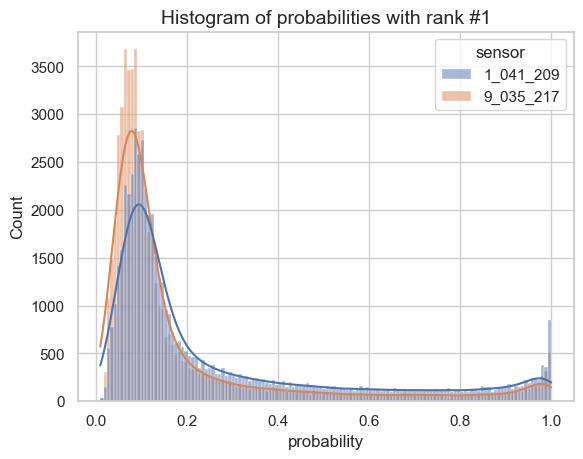

In [222]:
sns.histplot(data=df, x="probability", hue="sensor", kde=True) \
    .set_title('Histogram of probabilities with rank #1', fontdict={'size': 14})
plt.savefig("data/images/probability_histogram_r1.png", bbox_inches="tight")

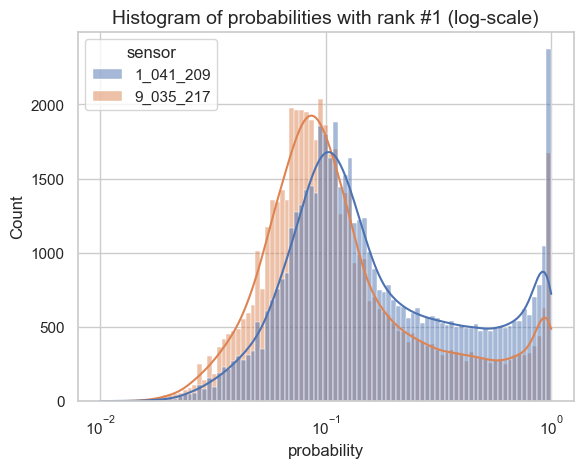

In [158]:
sns.histplot(data=df, x="probability", hue="sensor", log_scale=True, kde=True) \
    .set_title('Histogram of probabilities with rank #1 (log-scale)', fontdict={'size': 14})
plt.savefig("data/images/probability_histogram_r1_log_scale.png", bbox_inches="tight")

In [159]:
df = con.sql('''
    SELECT
        sensor,
        probability,
    FROM
        model_multi_results
    WHERE
        probability_rank = 2 AND
        CAST(start_observation_dt AS DATE) < '2023-01-08'
''').to_df()

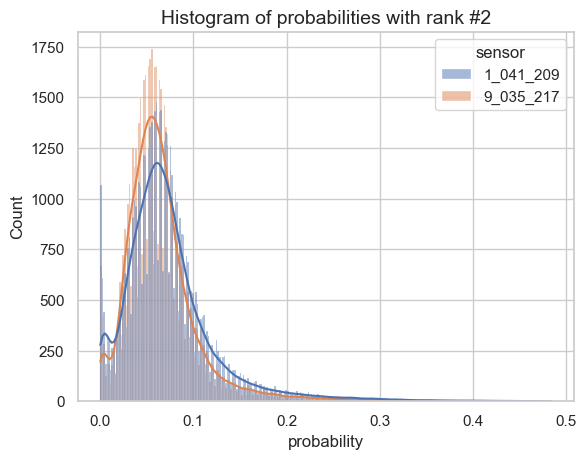

In [160]:
sns.histplot(data=df, x="probability", hue="sensor", kde=True) \
    .set_title('Histogram of probabilities with rank #2', fontdict={'size': 14})
plt.savefig("data/images/probability_histogram_r2.png", bbox_inches="tight")

## Explore the TBC model training results

In [224]:
mt = pd.read_csv('data/model_training.csv', sep=';')
mt

,Epoch,F1,Fold,Model
0,0,0.000000,0,ResNet
1,1,0.127660,0,ResNet
2,2,0.223623,0,ResNet
3,3,0.388445,0,ResNet
4,4,0.494015,0,ResNet
...,...,...,...,...
106,22,0.862250,4,EfficientNet
107,24,0.865598,4,EfficientNet
108,25,0.867045,4,EfficientNet
109,26,0.873215,4,EfficientNet


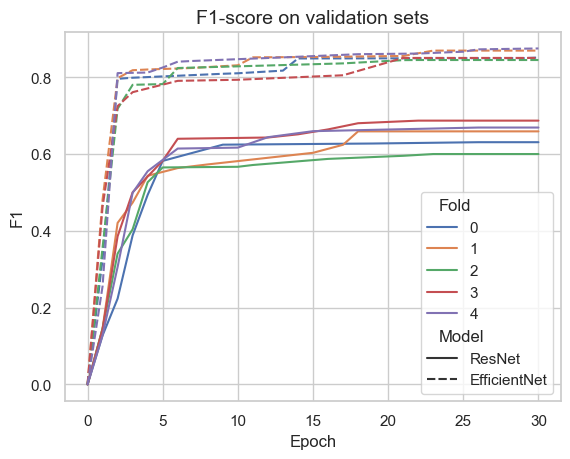

In [234]:
sns.lineplot(data=mt, x="Epoch", y="F1", hue="Fold", style="Model", palette=sns.color_palette()[:5]) \
    .set_title('F1-score on validation sets', fontdict={'size': 14})
plt.savefig("data/images/f1_scores_three_bird_model.png", bbox_inches="tight")

In [235]:
con.sql('''
    SELECT
        Model,
        AVG(F1) AS "Average F1"
    FROM
        mt
    WHERE
        Epoch = 30
    GROUP BY
        Model
''').to_df()

,Model,Average F1
0,ResNet,0.649638
1,EfficientNet,0.858742


## Looking at the rain data

In [368]:
rain = con.sql('''
    SELECT date, SUM(rain) AS "rain"
    FROM rain_per_hour
    WHERE date < '2023-01-08'
    GROUP BY date
''').to_df()

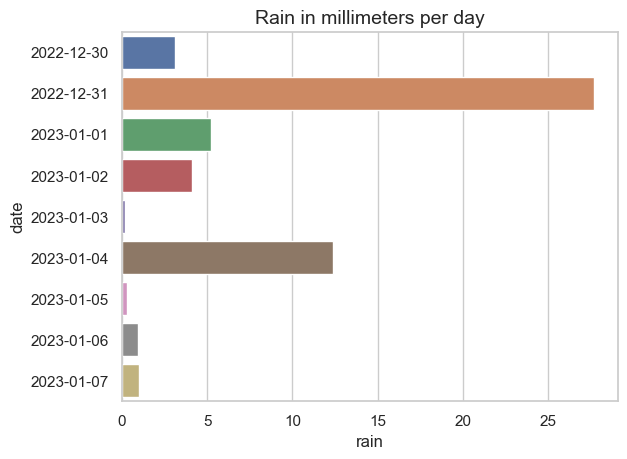

In [369]:
hue_dates = rain['date'].dt.strftime('%Y-%m-%d')
plot = sns.barplot(data=rain, x="rain", y=hue_dates, orient="h") \
    .set_title('Rain in millimeters per day', fontdict={'size': 14})
plt.savefig("data/images/rain_per_day.png", bbox_inches="tight")

## Create the data used for validation by experts

In [178]:
con.sql('''
    DROP TABLE classification_validation
''')

CatalogException: Catalog Error: Table with name classification_validation does not exist!
Did you mean "validation_tl"?

In [179]:
con.sql('''
    CREATE TABLE classification_validation AS
    SELECT
        ROW_NUMBER() OVER() AS id,
        mr.sensor,
        mr.start_observation_dt,
        mr.start_observation_dt + INTERVAL 5 SECOND AS end_observation_dt,
        mr.class,
        eb.SCI_NAME AS scientific_name,
        CASE WHEN bo.species IS NULL THEN 1 ELSE 0 END AS not_in_NL_ind,
        mr.probability,
        mr.probability_rank
    FROM (
        SELECT
            *
        FROM
            model_multi_results
        WHERE
            CAST(start_observation_dt AS DATE) = '2023-01-03' AND
            probability >= 0.3
    ) mr
    LEFT JOIN
        ebird AS eb
    ON
        mr.class = eb.SPECIES_CODE
    LEFT JOIN
        gbif AS bo
    ON
        LOWER(eb.SCI_NAME) = LOWER(bo.species)
    USING
        SAMPLE 300 ROWS
''')

## Grouped timeline exploration
This section explores the possibilities for creating a grouped timeline if consecutive observations get the same classifications.

In [139]:
con.sql('''
    DROP TABLE validation_tl;
    CREATE TABLE validation_tl AS
    SELECT
        mr.*,
        mr.start_observation_dt + INTERVAL 5 SECOND AS end_observation_dt
    FROM
        model_multi_results AS mr
    WHERE
        start_observation_dt >= '2023-01-03 07:00:00' AND
        start_observation_dt <= '2023-01-03 07:30:00' AND
        sensor = '1_041_209' AND
        probability_rank = 1
    ORDER BY
        mr.start_observation_dt;
''')

In [140]:
df = con.sql('''
    SELECT
        *,
        ROW_NUMBER() OVER (ORDER BY start_observation_dt) - ROW_NUMBER() OVER (PARTITION BY class ORDER BY start_observation_dt) AS rn
    FROM
        validation_tl
    ORDER BY
        start_observation_dt
''').to_df()

In [143]:
df = con.sql('''
    SELECT
        MIN(tl.start_observation_dt) AS start_obs,
        MAX(tl.end_observation_dt) AS end_obs,
        tl.class,
        MIN(tl.probability) AS min_probability,
        AVG(tl.probability) AS avg_probability,
        MAX(tl.probability) AS max_probability
    FROM (
        SELECT
            *,
            ROW_NUMBER() OVER (ORDER BY start_observation_dt) - ROW_NUMBER() OVER (PARTITION BY class ORDER BY start_observation_dt) AS rn
        FROM
            validation_tl
    ) AS tl
    GROUP BY
        tl.class,
        tl.rn
    HAVING
        avg_probability >= 0.3
    ORDER BY
        start_obs
''').to_df()

In [144]:
df

,start_obs,end_obs,class,min_probability,avg_probability,max_probability
0,2023-01-03 07:00:00,2023-01-03 07:00:35,eurrob1,0.411,0.649143,0.905
1,2023-01-03 07:00:35,2023-01-03 07:00:40,hawfin,0.501,0.501000,0.501
2,2023-01-03 07:00:40,2023-01-03 07:02:20,eurrob1,0.261,0.741000,0.993
3,2023-01-03 07:02:20,2023-01-03 07:03:00,eurbla,0.356,0.709625,0.992
4,2023-01-03 07:03:05,2023-01-03 07:03:20,eurbla,0.547,0.794333,0.946
...,...,...,...,...,...,...
101,2023-01-03 07:29:35,2023-01-03 07:29:40,gretit1,0.539,0.539000,0.539
102,2023-01-03 07:29:40,2023-01-03 07:29:45,eurrob1,0.772,0.772000,0.772
103,2023-01-03 07:29:45,2023-01-03 07:29:55,eurnut2,0.890,0.934500,0.979
104,2023-01-03 07:29:55,2023-01-03 07:30:00,eurrob1,0.845,0.845000,0.845


## Explore and combine eBird and GBIF

In [28]:
# Load eBird Taxonomy
ebird = pd.read_excel('data/ebird_taxonomy_v2022.xlsx')
ebird[['SPECIES_CODE', 'SCI_NAME', 'PRIMARY_COM_NAME']]

,SPECIES_CODE,SCI_NAME,PRIMARY_COM_NAME
0,ostric2,Struthio camelus,Common Ostrich
1,ostric3,Struthio molybdophanes,Somali Ostrich
2,y00934,Struthio camelus/molybdophanes,Common/Somali Ostrich
3,grerhe1,Rhea americana,Greater Rhea
4,lesrhe2,Rhea pennata,Lesser Rhea
...,...,...,...
16855,slcgro1,Saltator grossus,Slate-colored Grosbeak
16856,bltgro2,Saltator fuliginosus,Black-throated Grosbeak
16857,saltat1,Saltator sp.,saltator sp.
16858,passer1,Passeriformes sp.,passerine sp.


In [5]:
gbif = pd.read_csv('data/csv/gbif_species_netherlands.csv', sep='\t')
gbif[['species', 'taxonomicStatus']]

,species,taxonomicStatus
0,Erythropygia galactotes,SYNONYM
1,Tryngites subruficollis,SYNONYM
2,Aegypius monachus,ACCEPTED
3,Oenanthe pleschanka,ACCEPTED
4,Leucophaeus pipixcan,ACCEPTED
...,...,...
509,Ficedula parva,ACCEPTED
510,Anthus pratensis,ACCEPTED
511,Coccothraustes coccothraustes,ACCEPTED
512,Aquila chrysaetos,ACCEPTED


In [10]:
con.sql('''
    SELECT
        taxonomicStatus,
        COUNT(*) AS number
    FROM
        gbif
    GROUP BY
        taxonomicStatus
    ORDER BY
        taxonomicStatus
''').to_df()

,taxonomicStatus,number
0,ACCEPTED,472
1,DOUBTFUL,1
2,SYNONYM,41


In [11]:
con.sql('''
    SELECT
        bo.taxonomicStatus,
        COUNT(*) AS number
    FROM
        gbif AS bo
    LEFT JOIN
        ebird AS eb
    ON
        LOWER(bo.species) = LOWER(eb.SCI_NAME)
    WHERE
        eb.SPECIES_CODE IS NOT NULL
    GROUP BY
        bo.taxonomicStatus
    ORDER BY
        bo.taxonomicStatus
''').to_df()

,taxonomicStatus,number
0,ACCEPTED,472
1,DOUBTFUL,1
2,SYNONYM,3


In [30]:
con.sql('''
    SELECT
        bo.species,
        bo.speciesAlt,
        eb.PRIMARY_COM_NAME AS commonName,
        bo.taxonomicStatus,
        bo.numberOfOccurrences,
        eb.SPECIES_CODE AS eBirdCode
    FROM (
        SELECT
            *,
            concat(
                split_part(scientificName, ' ', 1),
                ' ',
                split_part(scientificName, ' ', 2)
            ) AS speciesAlt
        FROM
            gbif     
    ) AS bo
    LEFT JOIN
        ebird AS eb
    ON
        LOWER(bo.species) = LOWER(eb.SCI_NAME) OR
        LOWER(bo.speciesAlt) = LOWER(eb.SCI_NAME)
    ORDER BY
        bo.numberOfOccurrences DESC
    LIMIT
        20
''').to_df()

,species,speciesAlt,commonName,taxonomicStatus,numberOfOccurrences,eBirdCode
0,Corvus corone,Corvus corone,Carrion Crow,ACCEPTED,32158,carcro1
1,Anas platyrhynchos,Anas platyrhynchos,Mallard,ACCEPTED,31963,mallar3
2,Columba palumbus,Columba palumbus,Common Wood-Pigeon,ACCEPTED,31028,cowpig1
3,Fulica atra,Fulica atra,Eurasian Coot,ACCEPTED,29379,eurcoo
4,Turdus merula,Turdus merula,Eurasian Blackbird,ACCEPTED,28783,eurbla
5,Parus major,Parus major,Great Tit,ACCEPTED,28521,gretit1
6,Chroicocephalus ridibundus,Chroicocephalus ridibundus,Black-headed Gull,ACCEPTED,27680,bkhgul
7,Coloeus monedula,Corvus monedula,Eurasian Jackdaw,SYNONYM,25245,eurjac
8,Pica pica,Pica pica,Eurasian Magpie,ACCEPTED,25142,eurmag1
9,Ardea cinerea,Ardea cinerea,Gray Heron,ACCEPTED,24631,graher1


In [23]:
con.sql('''
    SELECT
        bo.species,
        bo.taxonomicStatus,
        bo.numberOfOccurrences,
        eb.SPECIES_CODE AS ebird_code
    FROM
        gbif AS bo
    LEFT JOIN
        ebird AS eb
    ON
        LOWER(bo.species) = LOWER(eb.SCI_NAME)
    WHERE
        eb.SPECIES_CODE IS NOT NULL
''').to_df()

,species,taxonomicStatus,numberOfOccurrences,ebird_code
0,Dendrocygna viduata,ACCEPTED,1,wfwduc1
1,Anser indicus,ACCEPTED,474,bahgoo
2,Anser anser,ACCEPTED,24313,gragoo
3,Anser cygnoides,ACCEPTED,1,swagoo1
4,Anser erythropus,ACCEPTED,239,lwfgoo
...,...,...,...,...
471,Parkesia noveboracensis,ACCEPTED,4,norwat
472,Setophaga striata,ACCEPTED,5,bkpwar
473,Setophaga coronata,ACCEPTED,3,yerwar
474,Motacilla citreola,ACCEPTED,11,citwag


## Create birds in NL list
This section creates the database of birds that occurred in The Netherlands based on GBIF data with the eBird code

In [31]:
con.sql('DROP TABLE ebird_in_netherlands')

In [32]:
con.sql('''
    CREATE TABLE ebird_in_netherlands AS
    SELECT
        bo.species,
        bo.speciesAlt,
        eb.PRIMARY_COM_NAME AS commonName,
        bo.taxonomicStatus,
        bo.numberOfOccurrences,
        eb.SPECIES_CODE AS eBirdCode
    FROM (
        SELECT
            *,
            concat(
                split_part(scientificName, ' ', 1),
                ' ',
                split_part(scientificName, ' ', 2)
            ) AS speciesAlt
        FROM
            gbif     
    ) AS bo
    LEFT JOIN
        ebird AS eb
    ON
        LOWER(bo.species) = LOWER(eb.SCI_NAME) OR
        LOWER(bo.speciesAlt) = LOWER(eb.SCI_NAME)
    ORDER BY
        bo.numberOfOccurrences DESC
''')

## More data exploration

In [33]:
df = con.sql('''
    SELECT
        rs.*,
        bo.SCI_NAME,
    FROM
        model_multi_results AS rs
    LEFT JOIN
        ebird AS bo
    ON
        rs.class = bo.SPECIES_CODE
    WHERE
        rs.probability > 0.8 AND
        rs.class NOT IN (
            SELECT eBirdCode
            FROM ebird_in_netherlands
        )
    ORDER BY
        rs.start_observation_dt;
''').to_df()

In [34]:
df

,sensor,start_observation_dt,class,probability,probability_rank,SCI_NAME
0,9_035_217,2022-12-30 15:36:50,blujay,0.842,1,Cyanocitta cristata
1,1_041_209,2022-12-31 15:24:00,varthr,0.837,1,Ixoreus naevius
2,1_041_209,2022-12-31 15:40:55,sharpb1,0.835,1,Oxyruncus cristatus
3,1_041_209,2022-12-31 15:48:40,sharpb1,0.975,1,Oxyruncus cristatus
4,1_041_209,2022-12-31 15:54:45,sharpb1,0.993,1,Oxyruncus cristatus
5,1_041_209,2022-12-31 16:19:05,sharpb1,0.825,1,Oxyruncus cristatus
6,1_041_209,2022-12-31 16:21:25,sharpb1,0.835,1,Oxyruncus cristatus
7,1_041_209,2022-12-31 16:22:40,slcant2,0.905,1,Grallaricula nana
8,1_041_209,2022-12-31 16:48:30,sharpb1,0.822,1,Oxyruncus cristatus
9,1_041_209,2022-12-31 21:45:20,slcant2,0.845,1,Grallaricula nana


In [34]:
df = con.sql('''
    SELECT
        COUNT(*)
    FROM
        model_multi_results AS rs
    WHERE
        rs.probability > 0.6
''').to_df()

In [35]:
df

,count_star()
0,13810


In [37]:
con.sql('''
    SELECT DISTINCT
        rs.class,
        bo.SCI_NAME,
    FROM
        model_multi_results AS rs
    LEFT JOIN
        ebird AS bo
    ON
        rs.class = bo.SPECIES_CODE
    WHERE
        rs.probability > 0.8 AND
        rs.class NOT IN (
            SELECT eBirdCode
            FROM ebird_in_netherlands
        )
    ORDER BY
        rs.class;
''').to_df()

,class,SCI_NAME
0,blujay,Cyanocitta cristata
1,blwthr1,Myophonus caeruleus
2,fiediu1,Pyrope pyrope
3,gockin,Regulus satrapa
4,grhowl,Bubo virginianus
5,grnwoo1,Picus viridis/sharpei
6,norcar,Cardinalis cardinalis
7,sharpb1,Oxyruncus cristatus
8,slcant2,Grallaricula nana
9,spotow,Pipilo maculatus


## Top 5 birds in Ede

In [52]:
df = con.sql('''
    SELECT
        ob.species AS "Scientific name",
        eb.PRIMARY_COM_NAME AS "Common name",
        ob.observation_cnt AS "Observations"
    FROM
        bird_observations_ede AS ob
    LEFT JOIN
        ebird AS eb
    ON
        LOWER(ob.species) = LOWER(eb.SCI_NAME)
    ORDER BY
        observation_cnt DESC
    LIMIT
        5
''').to_df()

In [53]:
df

,Scientific name,Common name,Observations
0,Parus major,Great Tit,729
1,Fringilla coelebs,Common Chaffinch,575
2,Dryocopus martius,Black Woodpecker,452
3,Buteo buteo,Common Buzzard,434
4,Sitta europaea,Eurasian Nuthatch,427


In [54]:
print(df.to_latex(index=False))

\begin{tabular}{llr}
\toprule
  Scientific name &       Common name &  Observations \\
\midrule
      Parus major &         Great Tit &           729 \\
Fringilla coelebs &  Common Chaffinch &           575 \\
Dryocopus martius &  Black Woodpecker &           452 \\
      Buteo buteo &    Common Buzzard &           434 \\
   Sitta europaea & Eurasian Nuthatch &           427 \\
\bottomrule
\end{tabular}



/var/folders/s_/42fztgr17fz_p63wzy307yvh0000gn/T/ipykernel_8218/1842088038.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(index=False))


## Birds not in Google model

In [62]:
df = con.sql('''
    SELECT
        ob.species AS "Scientific name",
        eb.PRIMARY_COM_NAME AS "Common name",
        ob.observation_cnt AS "Observations"
    FROM
        bird_observations_ede_sc AS ob
    LEFT JOIN
        ebird AS eb
    ON
         ob.ebird_code_def = eb.SPECIES_CODE
    WHERE
        ob.ebird_code_def IN ('crelar1', 'eugwoo2', 'sylvia1', 'rinphe1')
    ORDER BY
        observation_cnt DESC
''').to_df()

In [63]:
df

,Scientific name,Common name,Observations
0,Picus viridis,Eurasian Green Woodpecker,16
1,Phasianus colchicus,Ring-necked Pheasant,12
2,Galerida cristata,Crested Lark,1
3,Sylvia curruca,Sylvia/Curruca sp.,1


In [64]:
print(df.to_latex(index=False))

\begin{tabular}{llr}
\toprule
    Scientific name &               Common name &  Observations \\
\midrule
      Picus viridis & Eurasian Green Woodpecker &            16 \\
Phasianus colchicus &      Ring-necked Pheasant &            12 \\
  Galerida cristata &              Crested Lark &             1 \\
     Sylvia curruca &        Sylvia/Curruca sp. &             1 \\
\bottomrule
\end{tabular}



/var/folders/s_/42fztgr17fz_p63wzy307yvh0000gn/T/ipykernel_8218/1842088038.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(index=False))


## Example Google model output

In [65]:
sample = pd.read_csv('data/multi_results/9_035_217/20230103_060000.csv')

In [80]:
df = con.sql('''
    SELECT
        frame AS Frame,
        time AS Time,
        class AS Label,
        ROUND(probability, 5) AS "Prob.",
        probability_rank AS "Prob. rank"
    FROM
        sample
    WHERE
        (
            frame = 0 AND
            probability_rank <= 3
        ) OR (
            frame IN (802, 803, 804) AND
            probability_rank = 1
        ) OR (
            frame = 1038 AND
            probability_rank <= 2
        ) OR (
            frame = 2159 AND 
            probability_rank >= 4
        )
''').to_df()

In [81]:
print(df.to_latex(index=False))

\begin{tabular}{rllrr}
\toprule
 Frame &    Time &   Label &   Prob. &  Prob. rank \\
\midrule
     0 & 0:00:00 &  eurcoo & 0.13335 &           1 \\
     0 & 0:00:00 & tawowl1 & 0.06368 &           2 \\
     0 & 0:00:00 & watrai1 & 0.05355 &           3 \\
   802 & 1:06:50 & winwre4 & 0.99940 &           1 \\
   803 & 1:06:55 & winwre4 & 0.99916 &           1 \\
   804 & 1:07:00 & winwre4 & 0.99886 &           1 \\
  1038 & 1:26:30 &  hawfin & 0.66325 &           1 \\
  1038 & 1:26:30 & martit2 & 0.07366 &           2 \\
  2159 & 2:59:55 &  eurbla & 0.03521 &           4 \\
  2159 & 2:59:55 & shttre1 & 0.03246 &           5 \\
\bottomrule
\end{tabular}



/var/folders/s_/42fztgr17fz_p63wzy307yvh0000gn/T/ipykernel_8218/1842088038.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(index=False))


In [236]:
con.sql('''
    SHOW TABLE model_multi_results
''').to_df()

,column_name,column_type,null,key,default,extra
0,sensor,VARCHAR,YES,NaN,NaN,NaN
1,start_observation_dt,TIMESTAMP,YES,NaN,NaN,NaN
2,class,VARCHAR,YES,NaN,NaN,NaN
3,probability,"DECIMAL(18,3)",YES,NaN,NaN,NaN
4,probability_rank,INTEGER,YES,NaN,NaN,NaN


In [196]:
df = con.sql('''
    SELECT
        gen || ' ' || sp AS "Scientific name",
        q AS Quality,
        CAST(ROUND(AVG(
            CAST(split_part(length, ':', 1) AS INTEGER) +
            CAST(split_part(length, ':', 2) AS INTEGER)
        ), 0) AS INTEGER) AS "Avg. lth.",
        CAST(MEDIAN(
            CAST(split_part(length, ':', 1) AS INTEGER) +
            CAST(split_part(length, ':', 2) AS INTEGER)
        ) AS INTEGER) AS "Med. lth.",
        COUNT(*) AS Files
    FROM
        bird_recordings
    WHERE
        search_key IN ('galerida+cristata', 'picus+viridis', 'phasianus+colchicus')
    GROUP BY
        "Scientific name",
        Quality
    ORDER BY
        "Scientific name",
        Quality
''').to_df()

In [197]:
print(df.to_latex(index=False))

\begin{tabular}{llrrr}
\toprule
    Scientific name & Quality &  Avg. lth. &  Med. lth. &  Files \\
\midrule
  Galerida cristata &       A &         24 &         20 &    112 \\
  Galerida cristata &       B &         20 &         17 &    199 \\
Phasianus colchicus &       A &         14 &          8 &    120 \\
Phasianus colchicus &       B &         14 &          9 &    139 \\
      Picus viridis &       A &         16 &         10 &    233 \\
      Picus viridis &       B &         12 &          8 &    256 \\
\bottomrule
\end{tabular}



/var/folders/s_/42fztgr17fz_p63wzy307yvh0000gn/T/ipykernel_8218/1842088038.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(index=False))


In [176]:
con.sql('''
    SELECT
        *
    FROM
        ebird_in_netherlands
    WHERE
        eBirdCode = 'norsho'
''').to_df()

,species,speciesAlt,commonName,taxonomicStatus,numberOfOccurrences,eBirdCode
0,Anas clypeata,Spatula clypeata,Northern Shoveler,SYNONYM,9743,norsho


## Load and explore validation results

In [4]:
labeled_data = pd.read_excel('data/data_with_labels_v2.xlsx')

In [322]:
df = con.sql('''
    SELECT
        probability,
        sensor,
        CAST(CASE
            WHEN correct = '0?' THEN 0
            WHEN correct = '1?' THEN 1
            ELSE correct
        END AS INTEGER) AS "correctly classified"
    FROM
        labeled_data
    WHERE
        correct IS NOT NULL AND
        "correctly classified" != -1
''').to_df()

In [283]:
con.sql('''
    SELECT
        CASE WHEN probability >= 0.63 THEN 1 ELSE 0 END consider,
        "correctly classified",
        COUNT(*)
    FROM
        df
    GROUP BY
        consider,
        "correctly classified"
    ORDER BY
        consider,
        "correctly classified"
''').to_df()

,consider,correctly classified,count_star()
0,0,0,14
1,0,1,29
2,1,0,2
3,1,1,55


   true_neg  false_pos  false_neg  true_pos
0      14.0        2.0       29.0      55.0


<Axes: >

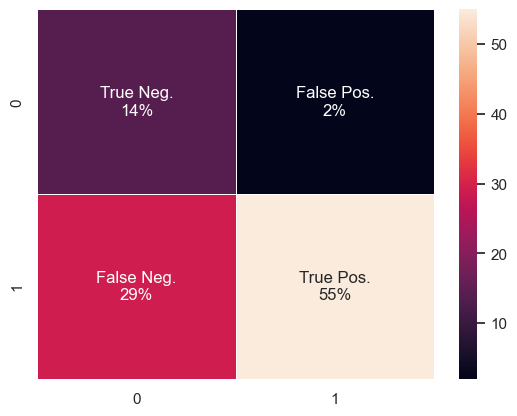

In [258]:
cfm = con.sql('''
    SELECT
        SUM(CASE WHEN probability < 0.630 AND "correctly classified" = 0 THEN 1 ELSE 0 END) AS true_neg,
        SUM(CASE WHEN probability >= 0.630 AND "correctly classified" = 0 THEN 1 ELSE 0 END) AS false_pos,
        SUM(CASE WHEN probability < 0.630 AND "correctly classified" = 1 THEN 1 ELSE 0 END) AS false_neg,
        SUM(CASE WHEN probability >= 0.630 AND "correctly classified" = 1 THEN 1 ELSE 0 END) AS true_pos
    FROM
        df
''').to_df()

print(cfm)

cfm = cfm.to_numpy().reshape([2, 2])

group_names = ['True Neg.', 'False Pos.', 'False Neg.', 'True Pos.']
group_percentages = ['{0:.0%}'.format(value) for value in
                     cfm.flatten() / np.sum(cfm)]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names, group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cfm, annot=labels, linewidth=.5, fmt='')

   true_neg  false_pos  false_neg  true_pos
0      11.0        5.0       23.0      61.0


<Axes: >

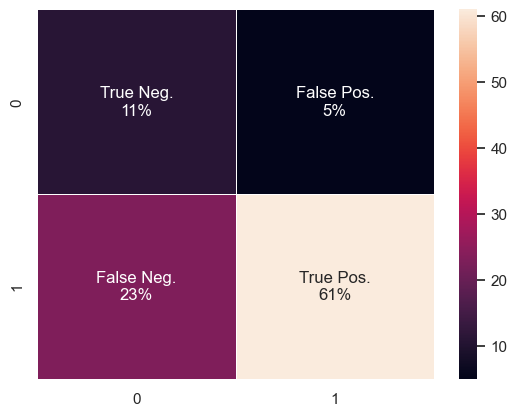

In [259]:
cfm = con.sql('''
    SELECT
        SUM(CASE WHEN probability < 0.533 AND "correctly classified" = 0 THEN 1 ELSE 0 END) AS true_neg,
        SUM(CASE WHEN probability >= 0.533 AND "correctly classified" = 0 THEN 1 ELSE 0 END) AS false_pos,
        SUM(CASE WHEN probability < 0.533 AND "correctly classified" = 1 THEN 1 ELSE 0 END) AS false_neg,
        SUM(CASE WHEN probability >= 0.533 AND "correctly classified" = 1 THEN 1 ELSE 0 END) AS true_pos
    FROM
        df
''').to_df()

print(cfm)

cfm = cfm.to_numpy().reshape([2, 2])

group_names = ['True Neg.', 'False Pos.', 'False Neg.', 'True Pos.']
group_percentages = ['{0:.0%}'.format(value) for value in
                     cfm.flatten() / np.sum(cfm)]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names, group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cfm, annot=labels, linewidth=.5, fmt='')

   true_neg  false_pos  false_neg  true_pos
0       4.0       12.0       10.0      74.0


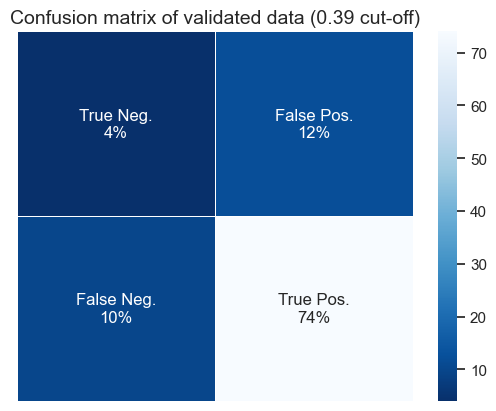

In [346]:
cfm = con.sql('''
    SELECT
        SUM(CASE WHEN probability < 0.39 AND "correctly classified" = 0 THEN 1 ELSE 0 END) AS true_neg,
        SUM(CASE WHEN probability >= 0.39 AND "correctly classified" = 0 THEN 1 ELSE 0 END) AS false_pos,
        SUM(CASE WHEN probability < 0.39 AND "correctly classified" = 1 THEN 1 ELSE 0 END) AS false_neg,
        SUM(CASE WHEN probability >= 0.39 AND "correctly classified" = 1 THEN 1 ELSE 0 END) AS true_pos
    FROM
        df
''').to_df()

print(cfm)

cfm = cfm.to_numpy().reshape([2, 2])

group_names = ['True Neg.', 'False Pos.', 'False Neg.', 'True Pos.']
group_percentages = ['{0:.0%}'.format(value) for value in
                     cfm.flatten() / np.sum(cfm)]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names, group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cfm, annot=labels, linewidth=.5, fmt='', cmap='Blues_r', xticklabels=False, yticklabels=False).set_title('Confusion matrix of validated data (0.39 cut-off)', fontdict={'size': 14})
plt.savefig("data/images/confusion_matrix_039_cut_off.png", bbox_inches="tight")

   true_neg  false_pos  false_neg  true_pos
0       0.0       16.0        0.0      84.0


<Axes: >

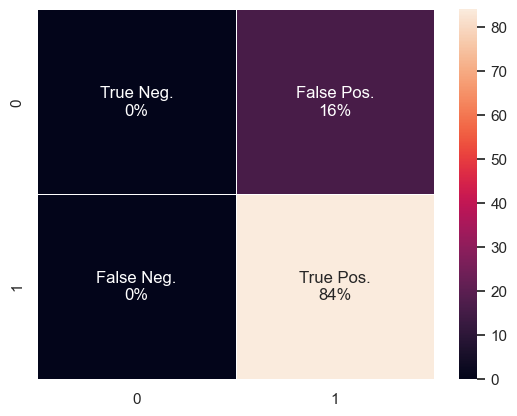

In [263]:
cfm = con.sql('''
    SELECT
        SUM(CASE WHEN probability < 0.3 AND "correctly classified" = 0 THEN 1 ELSE 0 END) AS true_neg,
        SUM(CASE WHEN probability >= 0.3 AND "correctly classified" = 0 THEN 1 ELSE 0 END) AS false_pos,
        SUM(CASE WHEN probability < 0.3 AND "correctly classified" = 1 THEN 1 ELSE 0 END) AS false_neg,
        SUM(CASE WHEN probability >= 0.3 AND "correctly classified" = 1 THEN 1 ELSE 0 END) AS true_pos
    FROM
        df
''').to_df()

print(cfm)

cfm = cfm.to_numpy().reshape([2, 2])

group_names = ['True Neg.', 'False Pos.', 'False Neg.', 'True Pos.']
group_percentages = ['{0:.0%}'.format(value) for value in
                     cfm.flatten() / np.sum(cfm)]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names, group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cfm, annot=labels, linewidth=.5, fmt='')

   true_neg  false_pos  false_neg  true_pos
0       5.0       11.0       13.0      71.0


<Axes: >

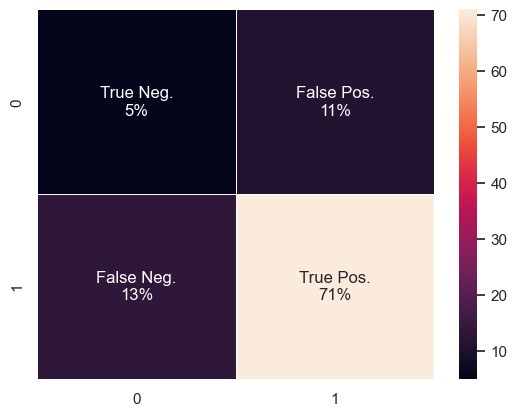

In [299]:
cfm = con.sql('''
    SELECT
        SUM(CASE WHEN probability < 0.4 AND "correctly classified" = 0 THEN 1 ELSE 0 END) AS true_neg,
        SUM(CASE WHEN probability >= 0.4 AND "correctly classified" = 0 THEN 1 ELSE 0 END) AS false_pos,
        SUM(CASE WHEN probability < 0.4 AND "correctly classified" = 1 THEN 1 ELSE 0 END) AS false_neg,
        SUM(CASE WHEN probability >= 0.4 AND "correctly classified" = 1 THEN 1 ELSE 0 END) AS true_pos
    FROM
        df
''').to_df()

print(cfm)

cfm = cfm.to_numpy().reshape([2, 2])

group_names = ['True Neg.', 'False Pos.', 'False Neg.', 'True Pos.']
group_percentages = ['{0:.0%}'.format(value) for value in
                     cfm.flatten() / np.sum(cfm)]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names, group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cfm, annot=labels, linewidth=.5, fmt='')

In [284]:
con.sql('''
    SELECT
        *
    FROM (
        SELECT
            0.533 AS prob_group,
            SUM("correctly classified") AS correct_cnt,
            COUNT(*) AS total_cnt,
            ROUND(CAST(correct_cnt AS DECIMAL) / CAST(total_cnt AS DECIMAL) * 100, 1) AS perc_correct
        FROM
            df
        WHERE
            probability >= 0.533

        UNION

        SELECT
            0.630 AS prob_group,
            SUM("correctly classified") AS correct_cnt,
            COUNT(*) AS total_cnt,
            ROUND(CAST(correct_cnt AS DECIMAL) / CAST(total_cnt AS DECIMAL) * 100, 1) AS perc_correct
        FROM
            df
        WHERE
            probability >= 0.630

        UNION

        SELECT
            0.679 AS prob_group,
            SUM("correctly classified") AS correct_cnt,
            COUNT(*) AS total_cnt,
            ROUND(CAST(correct_cnt AS DECIMAL) / CAST(total_cnt AS DECIMAL) * 100, 1) AS perc_correct
        FROM
            df
        WHERE
            probability >= 0.679

        UNION

        SELECT
            0.300 AS prob_group,
            SUM("correctly classified") AS correct_cnt,
            COUNT(*) AS total_cnt,
            ROUND(CAST(correct_cnt AS DECIMAL) / CAST(total_cnt AS DECIMAL) * 100, 1) AS perc_correct
        FROM
            df
        WHERE
            probability >= 0.300

        UNION

        SELECT
            0.390 AS prob_group,
            SUM("correctly classified") AS correct_cnt,
            COUNT(*) AS total_cnt,
            ROUND(CAST(correct_cnt AS DECIMAL) / CAST(total_cnt AS DECIMAL) * 100, 1) AS perc_correct
        FROM
            df
        WHERE
            probability >= 0.39
    )
    ORDER BY
        prob_group
''').to_df()

,prob_group,correct_cnt,total_cnt,perc_correct
0,0.300,84.0,100,84.0
1,0.390,74.0,86,86.0
2,0.533,61.0,66,92.4
3,0.630,55.0,57,96.5
4,0.679,49.0,50,98.0


In [300]:
con.sql('''
    SELECT
        SUM(CASE WHEN probability >= 0.30 THEN 1 ELSE 0 END) AS prob_30,
        SUM(CASE WHEN probability >= 0.38 THEN 1 ELSE 0 END) AS prob_38,
        SUM(CASE WHEN probability >= 0.39 THEN 1 ELSE 0 END) AS prob_39,
        SUM(CASE WHEN probability >= 0.40 THEN 1 ELSE 0 END) AS prob_40,
        SUM(CASE WHEN probability >= 0.45 THEN 1 ELSE 0 END) AS prob_45,
        SUM(CASE WHEN probability >= 0.50 THEN 1 ELSE 0 END) AS prob_50,
        SUM(CASE WHEN probability >= 0.60 THEN 1 ELSE 0 END) AS prob_60
    FROM
        model_multi_results
    WHERE
        CAST(start_observation_dt AS DATE) < '2023-01-08' AND
        class IN (
            SELECT eBirdCode
            FROM ebird_in_netherlands
        )
''').to_df()

,prob_30,prob_38,prob_39,prob_40,prob_45,prob_50,prob_60
0,24844.0,20484.0,20041.0,19602.0,17676.0,16010.0,13252.0


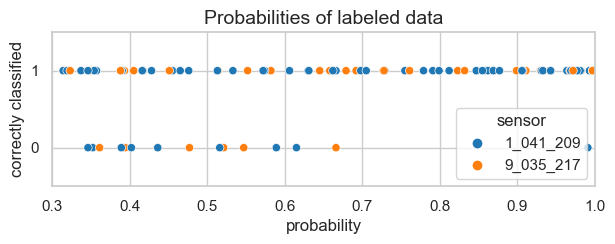

In [321]:
sns.set_style("whitegrid")
sns.set_context("notebook")
fig, ax = plt.subplots(figsize=(7, 2))
ax.margins(x=0, y=0.5)
plot = sns.scatterplot(df, y="correctly classified", x="probability", hue="sensor")
plot.set_yticks(range(2))
plot.set_xticks([0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plot.set_title('Probabilities of labeled data', fontdict={'size': 14})
plt.savefig("data/images/probability_of_labeled_data_per_sensor.png", bbox_inches="tight")

In [314]:
df = con.sql('''
    SELECT
        ROUND(probability, 2) AS "probability (rounded)",
        CAST(CASE
            WHEN correct = '0?' THEN 0
            WHEN correct = '1?' THEN 1
            ELSE correct
        END AS INTEGER) AS "correctly classified",
        COUNT(*) AS amount
    FROM
        labeled_data
    WHERE
        correct IS NOT NULL AND
        "correctly classified" != -1
    GROUP BY
        "probability (rounded)",
        "correctly classified"
''').to_df()

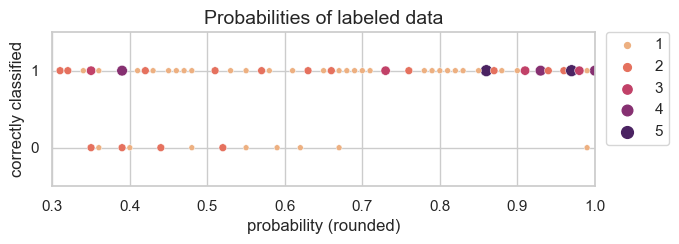

In [319]:
sns.set_style("whitegrid")
sns.set_context("notebook")
fig, ax = plt.subplots(figsize=(7, 2))
ax.margins(x=0, y=0.5)
plot = sns.scatterplot(df, y="correctly classified", x="probability (rounded)", hue="amount", size="amount", palette="flare")
plot.set_yticks(range(2))
plot.set_xticks([0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plot.set_title('Probabilities of labeled data', fontdict={'size': 14})
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.savefig("data/images/probability_of_labeled_data.png", bbox_inches="tight")

<Axes: xlabel='probability', ylabel='Count'>

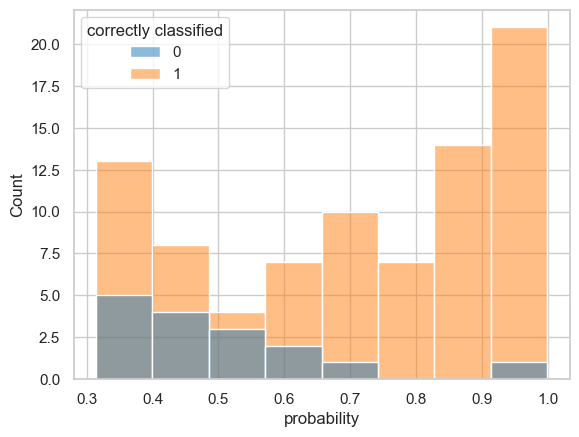

In [302]:
sns.histplot(data=df, x="probability", hue="correctly classified")

### Look at the other birds heard in the audio by the experts

In [18]:
con.sql('''
    SELECT
        mr.probability_rank,
        mr.sensor,
        COUNT(*) AS number
    FROM
        labeled_data AS ld
    INNER JOIN
        model_multi_results AS mr
    ON   
        (ld.start_observation_dt + INTERVAL 1 HOUR) = mr.start_observation_dt AND
        ld.sensor = mr.sensor AND (
            split_part(ld."other birds", ',', 1) = mr.class OR
            split_part(ld."other birds", ',', 2) = mr.class
        )
    WHERE
        ld."other birds" IS NOT NULL
    GROUP BY
        mr.probability_rank,
        mr.sensor
    ORDER BY   
        mr.sensor,
        mr.probability_rank
''').to_df()

,probability_rank,sensor,number
0,1,1_041_209,1
1,2,1_041_209,16
2,3,1_041_209,5
3,4,1_041_209,4
4,5,1_041_209,3
5,2,9_035_217,2
6,3,9_035_217,1


In [236]:
con.sql('''
    SELECT *
    FROM model_multi_results
    WHERE sensor = '1_041_209' AND start_observation_dt IN (
        '2023-01-03 08:15:05',
        '2023-01-03 09:33:00',
        '2023-01-03 07:52:25',
        '2023-01-03 08:14:20'
    )
''').to_df()

,sensor,start_observation_dt,class,probability,probability_rank
0,1_041_209,2023-01-03 08:15:05,eurtre1,0.346,1
1,1_041_209,2023-01-03 08:15:05,eurrob1,0.226,2
2,1_041_209,2023-01-03 08:15:05,hazgro1,0.103,3
3,1_041_209,2023-01-03 08:15:05,firecr1,0.039,4
4,1_041_209,2023-01-03 08:15:05,comchi1,0.029,5
5,1_041_209,2023-01-03 07:52:25,eurbla,0.516,1
6,1_041_209,2023-01-03 07:52:25,eurrob1,0.270,2
7,1_041_209,2023-01-03 07:52:25,sonthr1,0.025,3
8,1_041_209,2023-01-03 07:52:25,tawowl1,0.015,4
9,1_041_209,2023-01-03 07:52:25,misthr1,0.008,5


eurrob1 in de top 3

## More data exploration

In [47]:
con.sql('''
    SELECT
        *
    FROM
        model_multi_results
    WHERE
        CAST(start_observation_dt AS DATE) <= '2023-01-07' AND
        probability >= 0.39 AND
        class IN (
            SELECT eBirdCode
            FROM ebird_in_netherlands
        )
''').to_df()

,sensor,start_observation_dt,class,probability,probability_rank
0,9_035_217,2023-01-07 08:16:20,eurbla,0.586,1
1,9_035_217,2023-01-07 08:16:25,eurbla,0.478,1
2,9_035_217,2023-01-07 08:17:10,winwre4,0.802,1
3,9_035_217,2023-01-07 08:17:15,eurrob1,0.454,1
4,9_035_217,2023-01-07 08:18:40,eurbla,0.680,1
...,...,...,...,...,...
20036,9_035_217,2023-01-07 08:11:10,eurbla,0.791,1
20037,9_035_217,2023-01-07 08:11:15,eurbla,0.419,1
20038,9_035_217,2023-01-07 08:11:20,eurbla,0.854,1
20039,9_035_217,2023-01-07 08:11:25,eurbla,0.966,1


In [135]:
# SUM(CASE WHEN sensor = '1_041_209' THEN probability ELSE 0 END) AS city_prob,
# SUM(CASE WHEN sensor = '9_035_217' THEN probability ELSE 0 END) AS forest_prob
df = con.sql('''
    SELECT
        sensor,
        strftime(mr.start_observation_dt, '%y-%m-%d %H.') ||
        CASE WHEN MINUTE(mr.start_observation_dt) < 30 THEN '1' ELSE '2' END AS obs_date,
        COUNT(*) AS obs_cnt,
    FROM
        model_multi_results as mr
    WHERE
        probability >= 0.39 AND
        class IN (
            SELECT eBirdCode
            FROM ebird_in_netherlands
        ) AND (
            (
                CAST(mr.start_observation_dt AS DATE) = '2022-12-31' AND
                HOUR(mr.start_observation_dt) >= 15
            ) OR (
                CAST(mr.start_observation_dt AS DATE) = '2023-01-01'
            ) OR (
                CAST(mr.start_observation_dt AS DATE) = '2023-01-02' AND
                HOUR(mr.start_observation_dt) <= 9
            )
        )      
    GROUP BY
        sensor,
        obs_date
    ORDER BY
        sensor,
        obs_date
''').to_df()

In [141]:
df

,sensor,obs_date,obs_cnt
0,1_041_209,22-12-31 15.2,53
1,1_041_209,22-12-31 16.1,66
2,1_041_209,22-12-31 16.2,48
3,1_041_209,22-12-31 17.1,9
4,1_041_209,22-12-31 17.2,12
...,...,...,...
67,9_035_217,23-01-02 07.2,24
68,9_035_217,23-01-02 08.1,36
69,9_035_217,23-01-02 08.2,181
70,9_035_217,23-01-02 09.1,135


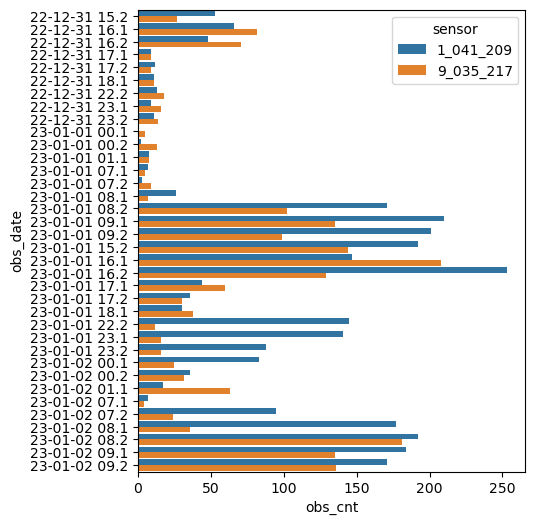

In [157]:
plt.subplots(figsize = (5, 6)) 
ax = sns.barplot(data=df, x="obs_cnt", y="obs_date", hue="sensor", orient='h', width=0.9)

# Set the number of ticks you want to display
# num_ticks = 18

# y = df['obs_date'].unique()

# tick_positions = [0, 5, 6, 11, 12, 17, 18, 23, 24, 29, 30, 35]

# Get the index positions for the desired ticks
# tick_positions = [i * (len(y) - 1) // (num_ticks - 1) for i in range(num_ticks)]

# Set the tick positions and labels
# ax.set_yticks(tick_positions)
# ax.set_yticklabels([y[i] for i in tick_positions])

## Visualizations to get a general idea of bird activity

In [40]:
# SUM(CASE WHEN sensor = '1_041_209' THEN probability ELSE 0 END) AS city_prob,
# SUM(CASE WHEN sensor = '9_035_217' THEN probability ELSE 0 END) AS forest_prob
df = con.sql('''
    SELECT
        obs_hour,
        obs_half_hour,
        sensor,
        ROUND(AVG(total_cnt), 0) AS "average count over days",
        ROUND(AVG(distinct_cnt), 1) AS "average distinct count over days"
    FROM (
        SELECT
            CAST(mr.start_observation_dt AS DATE) AS obs_date,
            LPAD(HOUR(mr.start_observation_dt), 2, '0') AS obs_hour,
            CASE WHEN MINUTE(mr.start_observation_dt) < 30 THEN 1 ELSE 2 END AS obs_half_hour,
            sensor,
            COUNT(*) AS total_cnt,
            COUNT(DISTINCT mr.class) AS distinct_cnt
        FROM
            model_multi_results as mr
        WHERE
            mr.probability >= 0.39 AND
            mr.class IN (
                SELECT eBirdCode
                FROM ebird_in_netherlands
            )
        GROUP BY
            obs_date,
            obs_hour,
            obs_half_hour,
            sensor
    )
    GROUP BY
        obs_hour,
        obs_half_hour,
        sensor
    ORDER BY
        obs_hour,
        obs_half_hour,
        sensor
''').to_df()

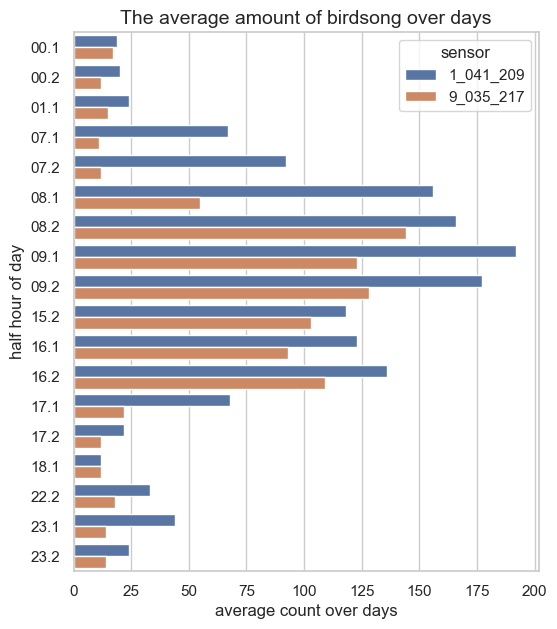

In [43]:
df['half hour of day'] = df['obs_hour'].astype(str) + '.' + df['obs_half_hour'].astype(str)
plot_order = df['half hour of day'].unique()
plot_order.sort()

sns.set_theme(style='whitegrid')
plt.subplots(figsize = (6, 7)) 
sns.barplot(data=df, x="average count over days", y="half hour of day", hue="sensor", order=plot_order, orient='h') \
    .set_title('The average amount of birdsong over days', fontdict={'size': 14})
plt.savefig("data/images/average_amount_of_birdsong.png", bbox_inches="tight")

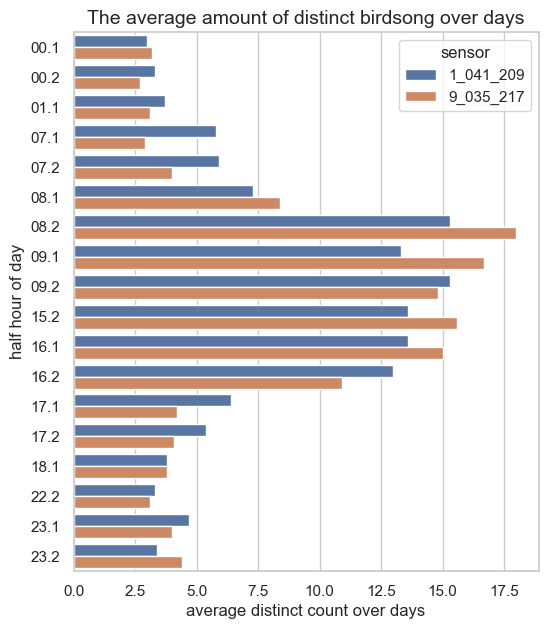

In [44]:
sns.set_theme(style='whitegrid')
plt.subplots(figsize = (6, 7)) 
sns.barplot(data=df, x="average distinct count over days", y="half hour of day", hue="sensor", order=plot_order, orient='h') \
    .set_title('The average amount of distinct birdsong over days', fontdict={'size': 14})
plt.savefig("data/images/average_amount_of_distinct_birdsong.png", bbox_inches="tight")

## Exploring unexpected peeks for discussion

In [713]:
pd.set_option('display.max_rows', 261)
con.sql('''
    SELECT
        *
    FROM
        model_multi_results
    WHERE
        class IN (
            SELECT eBirdCode
            FROM ebird_in_netherlands
        ) AND
        probability >= 0.39 AND
        CAST(start_observation_dt AS DATE) = '2022-12-31' AND
        HOUR(start_observation_dt) = 7 AND
        class != 'blawoo1'
''').to_df()

,sensor,start_observation_dt,class,probability,probability_rank
0,1_041_209,2022-12-31 07:04:45,loeowl,0.632,1
1,1_041_209,2022-12-31 07:23:40,tawowl1,0.854,1
2,1_041_209,2022-12-31 07:26:00,tawowl1,0.553,1
3,1_041_209,2022-12-31 07:26:40,tawowl1,0.640,1
4,1_041_209,2022-12-31 07:27:10,tawowl1,0.909,1
5,1_041_209,2022-12-31 07:29:35,tawowl1,0.962,1
6,1_041_209,2022-12-31 07:31:05,tawowl1,0.918,1
7,1_041_209,2022-12-31 07:31:10,tawowl1,0.957,1
8,1_041_209,2022-12-31 07:33:05,tawowl1,0.532,1
9,1_041_209,2022-12-31 07:33:30,tawowl1,0.904,1


## Sample of timeline for report

In [702]:
df = con.sql('''
    SELECT
        *
    FROM
        model_multi_results
    WHERE
        class IN (
            SELECT eBirdCode
            FROM ebird_in_netherlands
        )
    USING
        SAMPLE 6
    ORDER BY
        start_observation_dt
''').to_df()

In [703]:
df

,sensor,start_observation_dt,class,probability,probability_rank
0,1_041_209,2023-01-01 08:36:55,blutit,0.628,1
1,1_041_209,2023-01-02 08:19:10,martit2,0.077,2
2,9_035_217,2023-01-02 16:47:10,commoo3,0.058,3
3,1_041_209,2023-01-04 15:57:25,eurnut2,0.059,3
4,1_041_209,2023-01-07 07:59:35,tawowl1,0.031,4
5,1_041_209,2023-01-07 23:35:25,waldra1,0.317,1


In [704]:
print(df.to_latex(index=False))

\begin{tabular}{lllrr}
\toprule
   sensor & start\_observation\_dt &   class &  probability &  probability\_rank \\
\midrule
1\_041\_209 &  2023-01-01 08:36:55 &  blutit &        0.628 &                 1 \\
1\_041\_209 &  2023-01-02 08:19:10 & martit2 &        0.077 &                 2 \\
9\_035\_217 &  2023-01-02 16:47:10 & commoo3 &        0.058 &                 3 \\
1\_041\_209 &  2023-01-04 15:57:25 & eurnut2 &        0.059 &                 3 \\
1\_041\_209 &  2023-01-07 07:59:35 & tawowl1 &        0.031 &                 4 \\
1\_041\_209 &  2023-01-07 23:35:25 & waldra1 &        0.317 &                 1 \\
\bottomrule
\end{tabular}



/var/folders/s_/42fztgr17fz_p63wzy307yvh0000gn/T/ipykernel_3379/1842088038.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(index=False))


In [698]:
con.close()